# Make plots

In [2]:
%load_ext autoreload
%autoreload 2

# Import required modules

In [3]:
import numpy as np, os, sys, glob, tools

import getdist, cobaya
from getdist import plots, MCSamples

import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

from pylab import *
import tools

In [4]:
#plot(); show()

In [8]:
rcParams['figure.dpi'] = 150
rcParams['font.family'] = 'serif'
rcParams['figure.facecolor'] = 'white'
#plot(); show()

In [9]:
def make_ver_shades(ax, yarr, colorval = 'gray', alphaval = 0.05, zorder = -10):
    axhline(0., lw = 0.5, alpha = 0.2)
    delta_y = np.diff(yarr)[0]
    for ycntr, yval in enumerate( yarr ):
        if ycntr%2 == 0:
            y1 = yarr[ycntr] - delta_y/2.
            y2 = yarr[ycntr] + delta_y/2.
            axvspan(y1, y2, color = colorval, alpha = alphaval, zorder = zorder)
    return ax

def format_axis(ax, fx, fy, maxxloc=None, maxyloc = None):
    """
    function to format axis fontsize.


    Parameters
    ----------
    ax: subplot axis.
    fx: fontsize for xaxis.
    fy: fontsize for yaxis.
    maxxloc: total x ticks.
    maxyloc: total y ticks.

    Returns
    -------
    formatted axis "ax".
    """
    for label in ax.get_xticklabels(): label.set_fontsize(fx)
    for label in ax.get_yticklabels(): label.set_fontsize(fy)
    if maxyloc is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=maxxloc))
    if maxxloc is not None:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=maxxloc))
        
    ax.tick_params(which = 'major', direction='in', length=3, width=1.)
    ax.tick_params(which = 'minor', direction='in', length=1., width=1.)

    return ax


def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])#,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    #subax.xaxis.set_tick_params(labelsize=x_labelsize)
    #subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


# Cov checks

(9, 9) (9, 9) (9, 9) (9, 9) (9, 9) (9, 9)


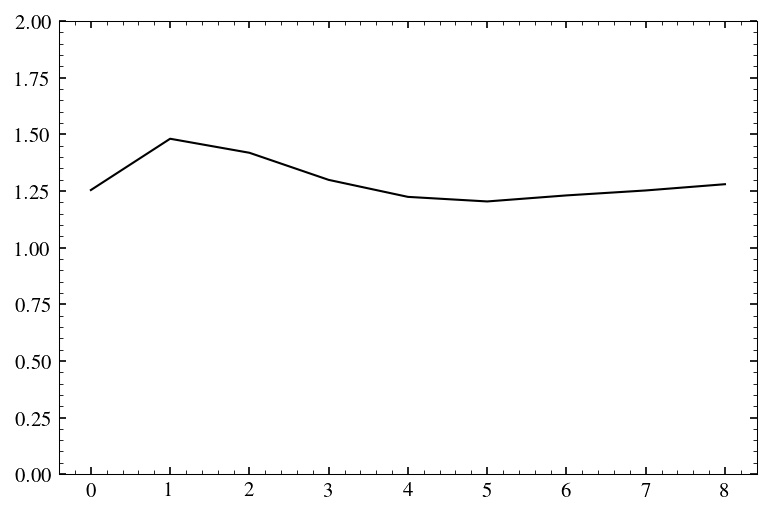

In [10]:
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()
##print(res_dic.keys()); sys.exit()
op_ps_1d_dic = res_dic['op_ps_1d_dic']
full_stat_cov = res_dic['full_stat_cov']
full_sys_cov_dic = res_dic['full_sys_cov_dic']
m1m2_arr = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')]
tmpels = res_dic[m1m2_arr[0]]['els']
linds = np.arange(len(tmpels))

final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                full_sys_cov_dic['cmb_withspiretcalerror'] + \
                full_sys_cov_dic['ksz']
            
full_cov = full_stat_cov + final_full_sys_cov


ilc_keyname1, ilc_keyname2, ilc_keyname3 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
tmpels = tmpels[linds]
curr_dl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
d1_undesired_comp = res_dic[ilc_keyname1]['sim'][linds]
d2_undesired_comp = res_dic[ilc_keyname2]['sim'][linds]
d3_undesired_comp = res_dic[ilc_keyname3]['sim'][linds]
d1 = res_dic[ilc_keyname1]['data_final'][linds]
d2 = res_dic[ilc_keyname2]['data_final'][linds]
d3 = res_dic[ilc_keyname3]['data_final'][linds]
reclen = len(d1)
curr_cov_11 = full_cov[:reclen, :reclen]
curr_cov_22 = full_cov[reclen:2*reclen, reclen:2*reclen]
curr_cov_33 = full_cov[2*reclen:, 2*reclen:]
curr_cov_12 = full_cov[reclen:2*reclen,:reclen]
curr_cov_13 = full_cov[2*reclen:,:reclen]
curr_cov_23 = full_cov[2*reclen:,reclen:2*reclen]
print(curr_cov_11.shape, curr_cov_22.shape, curr_cov_33.shape, curr_cov_12.shape, curr_cov_13.shape, curr_cov_23.shape)

if (1):
    curr_diff_cov = curr_cov_11 + curr_cov_22 - 2 * curr_cov_12
    which_sim = 'cl_arr_for_non_gau_cov'
    m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree')
    cl_aa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim)
    cl_bb_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim)
    cl_ab_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim)
    curr_diff_cov_v2 = tools.get_modified_cov(cl_aa_arr, cl_bb_arr, operation = 'subtract')
    
    #imshow(curr_diff_cov/curr_diff_cov_v2, vmin = 0., vmax = 10.); colorbar(); show()
    #imshow(curr_diff_cov_v2); colorbar(); show()    
    
    plot(np.diag(curr_diff_cov)/np.diag(curr_diff_cov_v2))
    ylim(0., 2)
    show()
    


In [11]:
if (0): #Check radio vs analytic
    fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
    res_dic = np.load(fname, allow_pickle=True).item()
    
    m1m2_a = ('ymv', 'ymv')
    m1m2_b = ('ycibfree', 'ycibfree')

    cl_rad_arr_a, cl_rad_arr_b = [], []
    for simno in range(100):
        cl_rad_arr_a.append( res_dic['op_ps_1d_dic']['rad'][simno][0][m1m2_a][1] )
        cl_rad_arr_b.append( res_dic['op_ps_1d_dic']['rad'][simno][0][m1m2_b][1] )        
    cl_rad_mean_a = np.mean(cl_rad_arr_a, axis = 0)
    cl_rad_mean_b = np.mean(cl_rad_arr_b, axis = 0)
    
    cl_rad_analytic_tucci_dn_ds_a = res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict'][m1m2_a]['tucci'][0.6]['res_ilc'] / 1e12
    cl_rad_analytic_tucci_dn_ds_b = res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict'][m1m2_b]['tucci'][0.6]['res_ilc'] / 1e12
    
    cl_rad_diff_ab = cl_rad_mean_a - cl_rad_mean_b
    cl_rad_diff_analytic_ab = cl_rad_analytic_tucci_dn_ds_a - cl_rad_analytic_tucci_dn_ds_b
    clf()
    show_diff = False
    binned_el = res_dic[m1m2_a]['els']
    binned_dl_fac = binned_el * (binned_el+1)/2/np.pi * 1e12
    ax = subplot(111)
    if show_diff:
        plot(binned_el, binned_dl_fac * cl_rad_diff_ab)
        plot(binned_el, binned_dl_fac * cl_rad_diff_analytic_ab)
        xlim(0., 5000.); ylim(-0.3, 0.3)
    else:
        plot(binned_el, binned_dl_fac * cl_rad_mean_a, color = 'royalblue')
        plot(binned_el, binned_dl_fac * cl_rad_analytic_tucci_dn_ds_a, color = 'royalblue', ls = '-.')
        plot(binned_el, binned_dl_fac * cl_rad_mean_b, color = 'navy')
        plot(binned_el, binned_dl_fac * cl_rad_analytic_tucci_dn_ds_b, color = 'navy', ls = '-.')
        xlim(0., 5000.); ylim(-0.05, 1.)
    xlabel(r'Multipole $\ell$', fontsize = 12)
    ylabel(r'$\Delta D_{\ell}^{yy}$', fontsize = 12, labelpad = 0.)
    axhline(0., lw = 0.5);
    show()
    
if (0): #Check which foreground difference is important
    fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
    res_dic = np.load(fname, allow_pickle=True).item()
    
    m1m2_a = ('ymv', 'ymv')
    m1m2_b = ('ycibfree', 'ycibfree')
    comp_dic = {#'cib': ['cib', 'orangered'],
                'cib_tweaked_spt_only_max_tweak_0.2': ['cib tweaked', 'darkred'],
                #'cib_tweaked': ['cib tweaked', 'darkred'],
                #'rad': ['rad', 'royalblue'],
                #'cmb': ['cmb', 'goldenrod'],
                #'ksz': ['ksz', 'olivedrab'],
                ###'noise': ['noise', 'purple'],
               }
    
    clf()
    show_diff = True #False
    binned_el = res_dic[m1m2_a]['els']
    binned_dl_fac = binned_el * (binned_el+1)/2/np.pi * 1e12
    for comp in comp_dic:
        clf()
        ax = subplot(111)
        labval, colorval = comp_dic[comp]
        cl_arr_a, cl_arr_b = [], []
        for simno in range(25):
            cl_arr_a.append( res_dic['op_ps_1d_dic'][comp][simno][0][m1m2_a][1] )
            cl_arr_b.append( res_dic['op_ps_1d_dic'][comp][simno][0][m1m2_b][1] )        
        cl_arr_a, cl_arr_b = np.asarray( cl_arr_a ), np.asarray( cl_arr_b )
        cl_mean_a = np.mean(cl_arr_a, axis = 0)
        cl_mean_b = np.mean(cl_arr_b, axis = 0)

        cl_diff_ab = cl_mean_a - cl_mean_b
        cl_diff_arr_ab = cl_arr_a - cl_arr_b
        if show_diff:
            plot(binned_el, binned_dl_fac * cl_diff_ab, color = colorval, label = labval)
            for cl_ in cl_diff_arr_ab:
                plot(binned_el, binned_dl_fac * cl_, color = colorval, lw = 0.2, alpha = 0.2)
            xlim(0., 5000.); ylim(-0.3, 0.3)
        else:
            plot(binned_el, binned_dl_fac * cl_mean_a, color = colorval, label = labval)
            plot(binned_el, binned_dl_fac * cl_mean_b, color = colorval, label = labval, ls = '--')
            xlim(0., 5000.); ylim(-0.05, 1.)
        if show_diff:
            xlim(0., 5000.); ylim(-0.3, 0.3)
        else:
            xlim(0., 5000.); ylim(-0.05, 1.)
        xlabel(r'Multipole $\ell$', fontsize = 12)
        ylabel(r'$\Delta D_{\ell}^{yy}$', fontsize = 12, labelpad = 0.)
        axhline(0., lw = 0.5);
        show()
    
    
        
    

# Check Herschel noise residuals and their impact on the final yy spectra

dict_keys(['op_ps_1d_dic', ('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv'), 'full_stat_cov', 'full_sys_cov_dic'])
(9, 9) (9, 9) (9, 9) (9, 9) (9, 9) (9, 9)


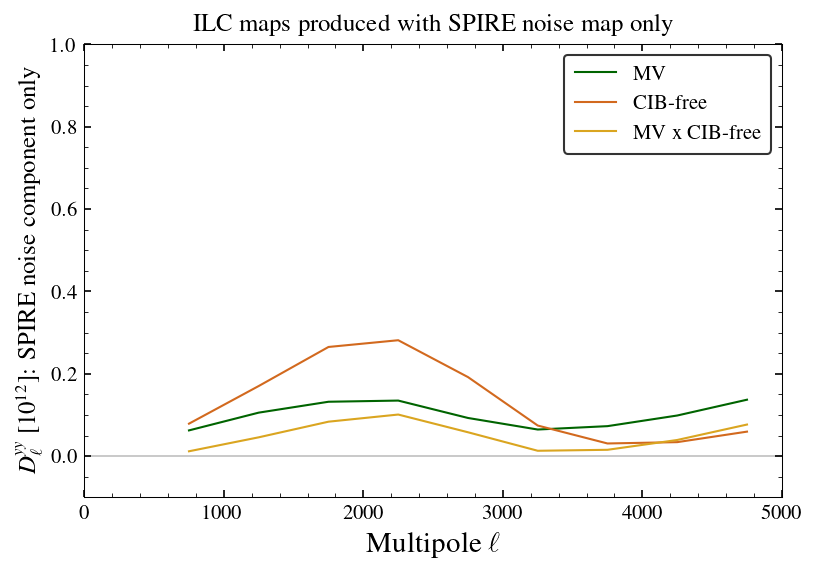

('ymv', 'ymv')
('ycibfree', 'ycibfree')
('ycibfree', 'ymv')
('ymv', 'ymv')
('ycibfree', 'ycibfree')
('ycibfree', 'ymv')


<Figure size 900x600 with 0 Axes>

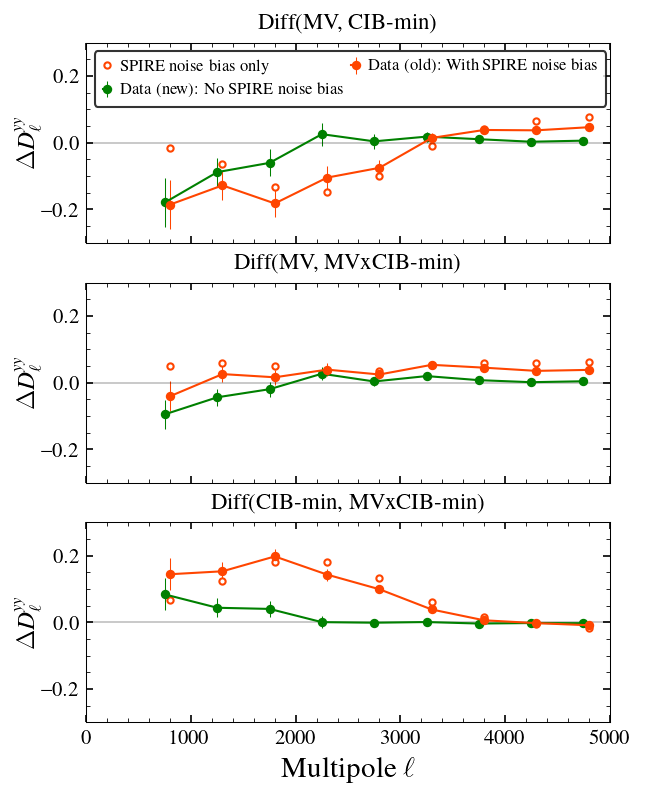

SystemExit: 

In [15]:
if (1): #Check which foreground difference is important
    
    """
    noise_dic_fname = 'results/noise_2d_allbands_forymap.npy'
    noise_iso_dic_fname = 'results/noise_2d_iso_allbands_forymap.npy'
    
    noise_dic = np.load(noise_dic_fname, allow_pickle = True).item()
    use_iso_noise_for_spire = False
    if use_iso_noise_for_spire:
        noise_iso_dic = np.load(noise_iso_dic_fname, allow_pickle = True).item()
    else:
        noise_iso_dic = {}
    print(noise_dic.keys())
    print(noise_iso_dic.keys())
    bands = list( noise_dic.keys() )
    nl_2D_dic = {}
    for nu in noise_dic:
        if nu in noise_iso_dic:
            nl_2D_dic[nu] = noise_iso_dic[nu]
        else:
            nl_2D_dic[nu] = noise_dic[nu]
    
    print(nl_2D_dic.keys())
    
    """

    import flatsky
    
    make_plots_only = True #False #True #False #True #False #True
    m1_m2_ilc_comb_arr_to_plot = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv'),]
    
    if not make_plots_only:
        fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
        res_dic = np.load(fname, allow_pickle=True).item()
        m1m2_arr = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')]
        tmpels = res_dic[m1m2_arr[0]]['els']

        #variables
        ilc_keyname_arr = ['ymv', 'ycibfree']
        dx = 0.5

        #weights
        weights_fname = 'results/ilc_weights_2D_lmax7001.npy'
        weights_dic = np.load( weights_fname, allow_pickle=True).item()
        print(weights_dic.keys())

        #process details
        process_details_dic_fname = 'results/process_details_numpy.npy'
        process_details_dic = np.load(process_details_dic_fname, allow_pickle=True).item()
        ##print(process_details_dic.keys()); sys.exit()
        bl_dic = process_details_dic['bl_dic']
        tf_twod = process_details_dic['tf_twod']
        filter_for_weights = process_details_dic['filter_for_weights']
        tf_beam_filter_2D_for_ps = filter_for_weights * bl_dic['effective']**2.# * np.copy( tf_twod )
        ##tf_beam_filter_2D_for_ps = tf_beam_filter_2D_for_ps**0.5    

        #masks
        mask_fname = 'results/masks.npy'
        mask_dic = np.load(mask_fname, allow_pickle=True).item()
        print( mask_dic.keys() ); ##sys.exit()
        apod_mask = mask_dic['apod_mask']
        mask = mask_dic['mask']


        #maps
        map_dic_fname = 'results/maps_used_for_ilc_forymap_spt3g90-spt3g150-sptpol150-spt3g220-spire600-spire857.npy'
        map_dic = np.load( map_dic_fname, allow_pickle=True).item()
        ##print(map_dic.keys())
        #sys.exit()

        expband_list = ['spt3g_90', 'spt3g_150', 'sptpol_150', 'spt3g_220', 'spire_600', 'spire_857']
        ilc_noise_res_dic = {}
        for tmpiter in range(2):
            if tmpiter == 0:
                scaling_for_noise = np.ones( len(expband_list) )
            elif tmpiter == 1:
                scaling_for_noise = np.ones( len(expband_list) )
                scaling_for_noise[:4] = 0.
            #noise maps
            noise_maparr_for_ilc = []
            for expcntr, expband in enumerate( expband_list ):
                expband_half1, expband_half2 = '%s_half1' %(expband), '%s_half2' %(expband)
                curr_noise_map = ( map_dic[expband_half1] - map_dic[expband_half2] )/2
                curr_noise_map = curr_noise_map * scaling_for_noise[expcntr]
                noise_maparr_for_ilc.append( curr_noise_map )

            ilc_map_dic = {}
            ny, nx = curr_noise_map.shape
            nbands = len(noise_maparr_for_ilc)
            for ilc_keyname in ilc_keyname_arr:# get the ilc combined map now
                weights = weights_dic[ilc_keyname][0].reshape(nbands, ny, nx)
                ##print(weights.shape); sys.exit()
                weighted_maparr = []
                for mm in range(len(noise_maparr_for_ilc)):
                    curr_map = noise_maparr_for_ilc[mm]
                    weights[mm][np.isnan(weights[mm])] = 0.0
                    weights[mm][np.isinf(weights[mm])] = 0.0
                    map_weighted = np.fft.ifft2(np.fft.fft2(curr_map) * weights[mm]).real
                    weighted_maparr.append(map_weighted)

                curr_ilc_map = np.sum(weighted_maparr, axis=0)
                ###imshow(curr_ilc_map); colorbar(); title(r'%s: %s' %(tmpiter, ilc_keyname)); show(); ##sys.exit()
                ilc_map_dic[ilc_keyname] = curr_ilc_map

            #compute power spectra
            delta_l, lmin, lmax = 500, 500, 5000 #20251117
            mapparams = [ny, nx, dx, dx]
            lx, ly = flatsky.get_lxly(mapparams)
            ell_grid = np.sqrt(lx**2.+ly**2.)
            ilc_noise_res_dic[tmpiter] = {}
            for ilc_keyname12 in m1_m2_ilc_comb_arr_to_plot:
                ilc_keyname1, ilc_keyname2 = ilc_keyname12
                curr_map1 = ilc_map_dic[ilc_keyname1] * mask
                curr_map2 = ilc_map_dic[ilc_keyname2] * mask

                el_, cl_ = flatsky.map2cl(mapparams, curr_map1, flatskymap2 = curr_map2, 
                                          binsize = delta_l, 
                                          minbin = lmin, 
                                          maxbin = lmax, 
                                          mask = mask, 
                                          filter_2d = tf_beam_filter_2D_for_ps)
                ##print(el_, cl_)
                ilc_noise_res_dic[tmpiter][ilc_keyname12] = [el_, cl_]

    #also get actual data now
    dl_fac = el_ * (el_+1)/2/np.pi# * 1e12
    pl_specs_dic = {('ymv', 'ymv'): ['darkgreen', r'MV'], 
                 ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-free'], 
                 ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-free'],
                }

    fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
    res_dic = np.load(fname, allow_pickle=True).item()
    print(res_dic.keys())
    
        #get cov
    full_stat_cov = res_dic['full_stat_cov']
    full_sys_cov_dic = res_dic['full_sys_cov_dic']
    final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                    full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                    full_sys_cov_dic['cmb_withspiretcalerror'] + \
                    full_sys_cov_dic['ksz']

    full_cov = full_stat_cov + final_full_sys_cov
    
    curr_cov_11 = full_cov[:reclen, :reclen]
    curr_cov_22 = full_cov[reclen:2*reclen, reclen:2*reclen]
    curr_cov_33 = full_cov[2*reclen:, 2*reclen:]
    curr_cov_12 = full_cov[reclen:2*reclen,:reclen]
    curr_cov_13 = full_cov[2*reclen:,:reclen]
    curr_cov_23 = full_cov[2*reclen:,reclen:2*reclen]
    print(curr_cov_11.shape, curr_cov_22.shape, curr_cov_33.shape, curr_cov_12.shape, curr_cov_13.shape, curr_cov_23.shape)
    
    data_pl_arr, data_pl_with_spire_noise_bias_arr = [], []
    for m1m2 in m1_m2_ilc_comb_arr_to_plot:
        el_ = res_dic[m1m2]['els']
        cl_data_final_with_spire_noise_bias = res_dic[m1m2]['data_final'] * 1e12
        cl_data_final = res_dic[m1m2]['data_final_odd_even_combs_only'] * 1e12
        data_pl_arr.append( cl_data_final )
        data_pl_with_spire_noise_bias_arr.append( cl_data_final_with_spire_noise_bias )
    
    clf()
    fsval = 14
    ax = subplot(111)
    for tmpiter in [1]:#ilc_noise_res_dic:
        if tmpiter == 0:
            lsval = '-.'
        else:
            lsval = '-'
        for m1m2 in ilc_noise_res_dic[tmpiter]:
            el_, cl_ = ilc_noise_res_dic[tmpiter][m1m2]
            colorval, labval = pl_specs_dic[m1m2]
            plot(el_, dl_fac * cl_, ls = lsval, color = colorval, label = labval)
    xlim(0., 5000.); ylim(-0.1, 1.)
    axhline(0., lw = 0.2)
    legend(loc = 1)
    title(r'ILC maps produced with SPIRE noise map only', fontsize = 12)
    ylabel(r'$D_{\ell}^{yy}$ [$10^{12}$]: SPIRE noise component only', fontsize = 12)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    show()
    
    pl_arr_dic = {}
    for tmpiter in [0, 1]:
        pl_arr = []
        for m1m2 in m1_m2_ilc_comb_arr_to_plot:
            print(m1m2)
            el_, cl_ = ilc_noise_res_dic[tmpiter][m1m2]
            pl_arr.append(cl_)
        pl_arr_dic[tmpiter] = pl_arr

    dl_fac = el_ * (el_+1)/2/np.pi
    diff_comb_arr = [[0,1], [0,2], [1,2]]

    clf()
    #figure(figsize = (8., 6.5))
    figure(figsize = (4.5, 6.))
    subplots_adjust(wspace=0.22)
    tr, tc = 3, 1 #2
    sbpl = tc
    for cntr, ij in enumerate(diff_comb_arr):
        if ij == [0,1]:
            title_val = r'Diff(MV, CIB-min)'        
            curr_diff_cov = curr_cov_11 + curr_cov_22 - 2 * curr_cov_12
        elif ij == [0,2]:
            title_val = r'Diff(MV, MVxCIB-min)'        
            curr_diff_cov = curr_cov_11 + curr_cov_33 - 2 * curr_cov_13
        elif ij == [1,2]:
            title_val = r'Diff(CIB-min, MVxCIB-min)'        
            curr_diff_cov = curr_cov_22 + curr_cov_33 - 2 * curr_cov_23
        curr_diff_vector_err = np.sqrt( np.diag( curr_diff_cov ) ) * 1e12
        ax = subplot(tr, tc, sbpl)
        i, j = ij
        tmp = pl_arr_dic[0][i] - pl_arr_dic[0][j]
        tmp_v2 = pl_arr_dic[1][i] - pl_arr_dic[1][j]    
        tmp_data = data_pl_arr[i] - data_pl_arr[j]
        tmp_data_with_spire_noise_bias = data_pl_with_spire_noise_bias_arr[i] - data_pl_with_spire_noise_bias_arr[j]
        errorbar(el_, tmp_data * dl_fac, yerr = curr_diff_vector_err * dl_fac, ls = '-', marker = 'o', color = 'green', ms = 3.5, label = r'Data (new): No SPIRE noise bias', capsize = 0., elinewidth = 0.5)    
        errorbar(el_+50, tmp_data_with_spire_noise_bias * dl_fac, yerr = curr_diff_vector_err * dl_fac, ls = '-', marker = 'o', color = 'orangered', ms = 3.5, label = r'Data (old): With SPIRE noise bias', capsize = 0., elinewidth = 0.5)   
        plot(el_+50, tmp_v2 * dl_fac, ls = 'None', marker = 'o', color = 'white', mec = 'orangered', ms = 3., label = r'SPIRE noise bias only')    
        ##plot(el_-50, tmp * dl_fac, ls = 'None', marker = 'o', color = 'black', ms = 3.)
        axhline(0., lw = 0.2)
        xlim(0., 5000.); ylim(-0.3, 0.3)
        title(title_val, fontsize =11)
        sbpl+=tc
        if cntr == 0:
            legend(loc = 2, fontsize = 8., handlelength = 0.5, ncol = 2, columnspacing = 0.5, handletextpad = 0.5)
        if cntr in [0, 1]:
            setp(ax.get_xticklabels(), visible=False)
        ylabel(r'$\Delta D_{\ell}^{yy}$', fontsize = 12, labelpad = 0.)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
        
    show()        
    
    sys.exit()
    

# SNR calculations

(9, 9) (9, 9) (9, 9) (9, 9) (9, 9) (9, 9)
('ymv', 'ymv')
9.381889011287448 9.381418321846153
('ycibfree', 'ycibfree')
9.215359602784254 9.216396408496076
('ycibfree', 'ymv')
9.398185455220457 9.397795957905478





tmpiter = 0
0.0 500 5000
[-1.20684449e-19  6.60308825e-20  6.84688647e-21 -8.76960012e-21
 -4.67067812e-21  1.35801301e-21  8.49146457e-22 -1.48135137e-21
  2.95789774e-22]

tmpiter = 1
0.0 500 5000
[-1.38909360e-19  1.60728673e-20 -1.82748513e-20 -1.33734536e-20
 -1.04235405e-21  1.31359715e-21  6.76965542e-22 -2.53916948e-22
  3.29535214e-22]

tmpiter = 2
0.0 500 5000
[-1.82249111e-20 -4.99580151e-20 -2.51217378e-20 -4.60385346e-21
  3.62832406e-21 -4.44158658e-23 -1.72180915e-22  1.22743442e-21
  3.37454399e-23]


<Figure size 900x600 with 0 Axes>

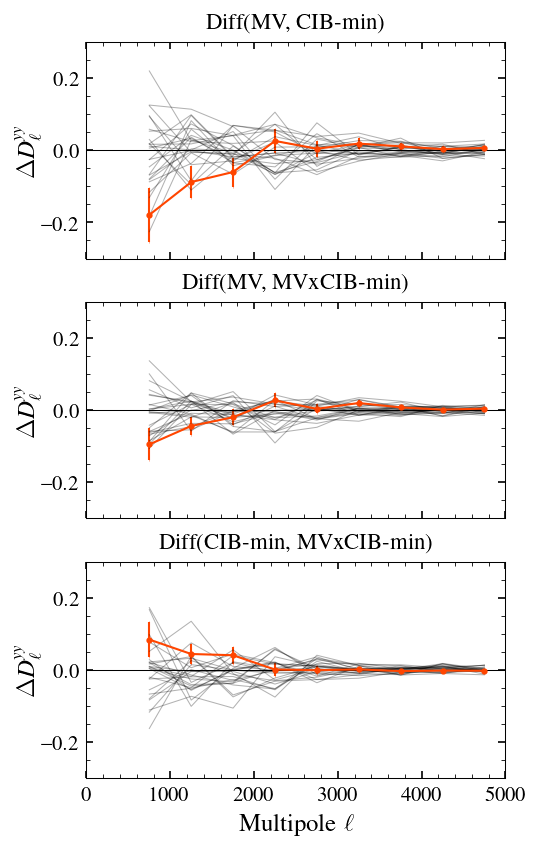

SystemExit: 

In [22]:
from scipy.stats import chi2
#fname = 'results/power_spectra_lmin500_lmax7000_deltal250/100d_tsz_final_estimate.npy'
#fname = 'results/power_spectra_lmin500_lmax7000_deltal250/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()
##print(res_dic.keys()); sys.exit()
op_ps_1d_dic = res_dic['op_ps_1d_dic']
full_stat_cov = res_dic['full_stat_cov']
full_sys_cov_dic = res_dic['full_sys_cov_dic']
##print(full_sys_cov_dic.keys()); sys.exit()
m1m2_arr = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')]
tmpels = res_dic[m1m2_arr[0]]['els']

final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                full_sys_cov_dic['cmb_withspiretcalerror'] + \
                full_sys_cov_dic['ksz'] + \
                full_sys_cov_dic['cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_tcal_tweaked']

            
full_cov = full_stat_cov + final_full_sys_cov

#sim tszxCIB estimates
masked_cib_tsz_ps_estimates = False #True #False
if masked_cib_tsz_ps_estimates:
    sim_tsz_cib_estimate_fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope_sim_tszcib_estimates.npy'
else:
    sim_tsz_cib_estimate_fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope_sim_tszcib_estimates_nomasking.npy'
sim_tsz_cib_estimate_dic = np.load( sim_tsz_cib_estimate_fname, allow_pickle=True).item()
#print(sim_tsz_cib_estimate_dic.keys()); sys.exit()

total_sims_for_tsz_cib = 50
sim_ps_dic = sim_tsz_cib_estimate_dic['sim_ps_dic']
bands = sim_tsz_cib_estimate_dic['bands']
ilc_1d_weights_dic = sim_tsz_cib_estimate_dic['ilc_1d_weights_dic']
#cl_yy_fromcibmindata = sim_tsz_cib_estimate_dic['cl_yy_fromcibmindata']
tmpiter_key = 'cibmindata_tsz' #'sim_tsz'
#tmpiter_key = 'sim_tsz' #'sim_tsz'
use_odd_even_combs_only = True
wl_dic = {}
for ilc_keyname in ['ymv', 'ycibfree']:
    wl_arr = []
    els = ilc_1d_weights_dic[ilc_keyname]['els']
    for freq in ilc_1d_weights_dic[ilc_keyname]:
        if freq == 'els': continue
        ###print(freq)
        binned_weights = ilc_1d_weights_dic[ilc_keyname][freq]                
        wl = np.interp( tmpels, els, binned_weights )
        wl_arr.append( wl )
    wl_arr = np.asarray(wl_arr)
    wl_dic[ilc_keyname] = wl_arr


#full_stat_corr = corr_from_cov(full_stat_cov)
##imshow(full_stat_corr); colorbar(); show()
linds = np.arange(len(tmpels))
if (0):
    #print( linds, tmpels[linds] )
    #linds = np.where(tmpels<=5000)[0]
    #linds = np.where(tmpels<4000)[0]
    #linds = np.where(tmpels<3500)[0]
    #linds = np.where(tmpels<4000)[0]
    #linds = np.where( (tmpels>3000) & (tmpels<5000) )[0]
    pass


ilc_keyname1, ilc_keyname2, ilc_keyname3 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
tmpels = tmpels[linds]
curr_dl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
d1_undesired_comp = res_dic[ilc_keyname1]['sim'][linds]
d2_undesired_comp = res_dic[ilc_keyname2]['sim'][linds]
d3_undesired_comp = res_dic[ilc_keyname3]['sim'][linds]
if use_odd_even_combs_only:
    d1 = res_dic[ilc_keyname1]['data_final_odd_even_combs_only'][linds]
    d2 = res_dic[ilc_keyname2]['data_final_odd_even_combs_only'][linds]
    d3 = res_dic[ilc_keyname3]['data_final_odd_even_combs_only'][linds]
else:
    d1 = res_dic[ilc_keyname1]['data_final'][linds]
    d2 = res_dic[ilc_keyname2]['data_final'][linds]
    d3 = res_dic[ilc_keyname3]['data_final'][linds]

reclen = len(d1)
curr_cov_11 = full_cov[:reclen, :reclen]
curr_cov_22 = full_cov[reclen:2*reclen, reclen:2*reclen]
curr_cov_33 = full_cov[2*reclen:, 2*reclen:]
curr_cov_12 = full_cov[reclen:2*reclen,:reclen]
curr_cov_13 = full_cov[2*reclen:,:reclen]
curr_cov_23 = full_cov[2*reclen:,reclen:2*reclen]
print(curr_cov_11.shape, curr_cov_22.shape, curr_cov_33.shape, curr_cov_12.shape, curr_cov_13.shape, curr_cov_23.shape)

"""
if (0): 
    clf()
    dl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
    plot(tmpels, dl_fac * d1, 'o', color = 'darkgreen')
    plot(tmpels, dl_fac * d2, 'o', color = 'peru')
    plot(tmpels, dl_fac * d3, 'o', color = 'goldenrod')
    ymin, ymax = -0.1, 1.1
    xmin, xmax = -100., 5100.
    xlim(xmin, xmax); ylim(ymin, ymax)
    show(); 

    clf()
    plot(tmpels, (d1-d2) * dl_fac, 'o', color = 'darkgreen')
    plot(tmpels, (d1-d3) * dl_fac, 'o', color = 'peru')
    plot(tmpels, (d2-d3) * dl_fac, 'o', color = 'goldenrod')
    ymin, ymax = -0.3, 0.3
    xmin, xmax = -100., 5100.
    axhline(0., lw = 0.5)
    xlim(xmin, xmax); ylim(ymin, ymax)
    show(); sys.exit()
"""

if (1):
    which_sim = 'cl_arr_for_non_gau_cov'
    m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree')
    cl_arr_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim)
    cl_bb_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim)
    cl_ab_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim)
    


use_full = False #True

for m1m2 in m1m2_arr:
    print(m1m2)
    D = res_dic[m1m2]['data_final_odd_even_combs_only'][linds]
    if use_full:
        D = res_dic[m1m2]['for_consistency_tests']['data_full']
    C = res_dic[m1m2]['total_cov'][linds[None,:], linds[:,None]]
    Cinv = np.linalg.inv(C)    
    chi_sq_val = np.dot(D, np.dot(D, Cinv))
    snr = np.sqrt( chi_sq_val )
    #print( snr )
    if (1):
        if m1m2 == ilc_keyname1:
            C_v2 = np.copy( curr_cov_11 )
        elif m1m2 == ilc_keyname2:
            C_v2 = np.copy( curr_cov_22 )
        elif m1m2 == ilc_keyname3:
            C_v2 = np.copy( curr_cov_33 )
        Cinv_v2 = np.linalg.inv(C_v2)
        chi_sq_val_v2 = np.dot(D, np.dot(D, Cinv_v2))
        snr_v2 = np.sqrt( chi_sq_val_v2 )
        print(snr, snr_v2)

print('\n\n\n')
#difference tests


#which_sim = 'cl_arr_for_non_gau_cov'
#which_sim = 'cl_sim_all_signals'
#which_sim = 'cib_cmb_rad_tsz_ksz_noise_rc5.1_noslope_spt3gbeams_compdependent_full'
#which_sim = 'cib_cmb_rad_tsz_ksz_noise_rc5.1_noslope_spt3gbeams_compdependent_half_splits'
#which_sim = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_full'
which_sim = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits'

if use_full:
    #which_sim = 'cib_cmb_rad_tsz_ksz_noise_rc5.1_noslope_spt3gbeams_compdependent_full'
    #which_sim = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_full'
    pass


clf()
figure(figsize = (8., 6.5))
subplots_adjust(wspace=0.22)
tr, tc = 3, 2
sbpl = 1
for tmpiter in range(3):
    #if tmpiter == 0: continue
    print('\ntmpiter = %s' %(tmpiter))
    if tmpiter == 0: #d1, d2
        #data
        curr_diff_vector = d1-d2
        curr_diff_cov = curr_cov_11 + curr_cov_22 - 2 * curr_cov_12

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim) - d1_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim) - d2_undesired_comp
        m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree')
        
        
        title_val = r'Diff(MV, CIB-min)'
        key_for_sima, key_for_simb = ilc_keyname1, ilc_keyname2
        undesired_comp_for_sima, undesired_comp_for_simb = d1_undesired_comp, d2_undesired_comp
    elif tmpiter == 1: #d1, d3
        curr_diff_vector = d1-d3
        curr_diff_cov = curr_cov_11 + curr_cov_33 - 2 * curr_cov_13

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim) - d1_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim) - d3_undesired_comp
        title_val = r'Diff(MV, MVxCIB-min)'
        m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ymv')
        key_for_sima, key_for_simb = ilc_keyname1, ilc_keyname3
        undesired_comp_for_sima, undesired_comp_for_simb = d1_undesired_comp, d3_undesired_comp
        
    elif tmpiter == 2: #d2, d3
        curr_diff_vector = d2-d3
        curr_diff_cov = curr_cov_22 + curr_cov_33 - 2 * curr_cov_23

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim) - d2_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim) - d3_undesired_comp
        title_val = r'Diff(CIB-min, MVxCIB-min)'
        m1, m2 = ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
        key_for_sima, key_for_simb = ilc_keyname2, ilc_keyname3
        undesired_comp_for_sima, undesired_comp_for_simb = d2_undesired_comp, d3_undesired_comp
        
    if (1): #recalculate cov locally
        curr_full_cov = tools.get_covs_for_difference_vectors(tmpels, key_for_sima, key_for_simb, op_ps_1d_dic)
        tmpreclen = int( len(curr_full_cov)/2 )
        curr_cov_aa = curr_full_cov[:tmpreclen, :tmpreclen]
        curr_cov_bb = curr_full_cov[tmpreclen:, tmpreclen:]
        curr_cov_ab = curr_full_cov[tmpreclen:, :tmpreclen]
        curr_diff_cov = curr_cov_aa + curr_cov_bb - 2 * curr_cov_ab
    
    if (0):
        close('all')
        clf()
        cl_err = np.sqrt( np.diag(curr_diff_cov) )
        binned_dl_fac = binned_el * (binned_el+1)/2/np.pi * 1e12
        plot(binned_el, binned_dl_fac * cl_err )
        xlim(0., 5000.); ylim(-0.01, 0.1)
        show(); sys.exit()


    chi_sq_val, chi_val = tools.get_null_test_chi_sq(curr_diff_vector, curr_diff_cov)
    pvalue = chi2.sf(chi_sq_val,len(curr_diff_vector)-1)
    ##sys.exit()

    tit_str = r'Correlated sims'
    if which_sim == 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits': #add sim tSZ/CIB here

        """
        reqd_tsz_cib_dic = {(500, 1000): 0.3, 
                            (1000, 1500): 0.3, 
                            (1500, 2000): 0.25, 
                            (2000, 2500): 0.25, 
                            (2500, 3000): 0.2, 
                            (3000, 4000): 0.1, 
                            (4000, 7000): 0.05, 
                           }
        """
        reqd_tsz_cib_dic = {(500, 1500): 0.2, 
                            (1500, 3000): 0.1, 
                            (3000, 5000): 0.05, 
                           }
        """
        reqd_tsz_cib_dic = {(500, 3000): 0.3, 
                            (3000, 5000): 0.05, 
                           }
        """

        """
        reqd_tsz_cib_dic = {(500, 5000): 0.3, 
                           }
        """
        reqd_tsz_cib_dic = {(500, 5000): 0., 
                           }
        
        """
        reqd_tsz_cib_dic = {(500, 1000): 0.17, 
                            (1000, 1500): 0.102, 
                            (1500, 2000): 0.08, 
                            (2000, 2500): 0.011, 
                            (2500, 3000): -0.021, 
                            (3000, 5000): 0.014, 
                           }        
        """
        tmp_color_arr = ['navy', 'darkgreen', 'goldenrod', 'orangered', 'darkred']
        cib_scatter_sigma = None #0.2
        include_beam_chromaticity = 0
        explicitly_null_tsz_cib_in_cibfree = 0 #0 ##1 ##0
        if (0):
            #perform fitting
            fit_rho_tsz_cib_arr = np.arange(-1, 1.025, 0.025) #0.025)
            #fit_rho_tsz_cib_arr = [0.,0.1, 0.2, 0.3, 0.4, 0.5]
            #fit_rho_tsz_cib_arr = [0.3, 0.4, 0.5]
            for tmpcntr, l1l2 in enumerate( reqd_tsz_cib_dic ):
                #print(l1l2)
                l1, l2 = l1l2
                curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]

                loglarr = []
                for fit_rho_tsz_cib in fit_rho_tsz_cib_arr:
                    sa_arr = tools.get_sim_arrary(res_dic, key_for_sima, which_sim) - undesired_comp_for_sima
                    sb_arr = tools.get_sim_arrary(res_dic, key_for_simb, which_sim) - undesired_comp_for_simb
                    
                    sa_arr, sb_arr, res_cib_a_arr, res_cib_b_arr = tools.account_for_tsz_cib_in_sims(fit_rho_tsz_cib, sa_arr, sb_arr, 
                                                                       sim_ps_dic, 
                                                                       bands, 
                                                                       wl_dic, 
                                                                       m1, m2,
                                                                       sim_tsz_cib_estimate_dic,
                                                                       total_sims_for_tsz_cib = total_sims_for_tsz_cib, 
                                                                       sim_or_data_tsz = tmpiter_key,
                                                                       reqd_linds = curr_rho_tsz_cib_linds, 
                                                                       cib_scatter_sigma = cib_scatter_sigma,
                                                                      )

                    curr_diff_vector_sim_arr = sa_arr - sb_arr
                    curr_diff_vector_sim_arr = curr_diff_vector_sim_arr[25:]

                    if (0):
                        close('all')
                        clf()
                        tmpdlfac = tmpels * (tmpels+1)/2/np.pi * 1e12
                        plot(tmpels, tmpdlfac * curr_diff_vector, color = 'orangered', marker = 'o')
                        for cl_ in curr_diff_vector_sim_arr:
                            plot(tmpels, tmpdlfac * cl_, color = 'gray')
                        xlim(0., 5000.); ylim(-0.3, 0.3)
                        show(); sys.exit()

                    #fitting
                    curr_data = curr_diff_vector[curr_rho_tsz_cib_linds]
                    curr_model = np.mean( curr_diff_vector_sim_arr, axis = 0)[curr_rho_tsz_cib_linds]
                    curr_cov = curr_diff_cov[curr_rho_tsz_cib_linds[None,:], curr_rho_tsz_cib_linds[:,None]]
                    loglval = tools.get_likelihood( curr_data, curr_model, curr_cov)
                    loglarr.append( loglval )

                recov_rho_tsz_cib_ind = np.argmax(loglarr)
                recov_rho_tsz_cib = fit_rho_tsz_cib_arr[recov_rho_tsz_cib_ind]
                reqd_tsz_cib_dic[l1l2] = recov_rho_tsz_cib

                larr = tools.get_likelihood_from_loglikelihood(loglarr)
                ##plot(fit_rho_tsz_cib_arr, larr, color = tmp_color_arr[tmpcntr])
            ##show(); ##sys.exit()
        
        ##print(reqd_tsz_cib_dic); sys.exit()
        tit_str = r'Uncorrelated sims with scale-dependent $\rho_{\rm tSZ x CIB}$'
        ##print(sa_arr[25])
        sa_arr = tools.get_sim_arrary(res_dic, key_for_sima, which_sim) - undesired_comp_for_sima
        sb_arr = tools.get_sim_arrary(res_dic, key_for_simb, which_sim) - undesired_comp_for_simb
        for l1l2 in reqd_tsz_cib_dic:
            reqd_tsz_cib = reqd_tsz_cib_dic[l1l2]
            l1, l2 = l1l2
            curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]
            print(reqd_tsz_cib, l1, l2)#, curr_rho_tsz_cib_linds)
            sa_arr, sb_arr, res_cib_a_arr, res_cib_b_arr = tools.account_for_tsz_cib_in_sims(reqd_tsz_cib, sa_arr, sb_arr, 
                                                               sim_ps_dic, 
                                                               bands, 
                                                               wl_dic, 
                                                               m1, m2,
                                                               sim_tsz_cib_estimate_dic,
                                                               total_sims_for_tsz_cib = total_sims_for_tsz_cib, 
                                                               sim_or_data_tsz = tmpiter_key,
                                                               reqd_linds = curr_rho_tsz_cib_linds, 
                                                               cib_scatter_sigma = cib_scatter_sigma,
                                                               include_beam_chromaticity = include_beam_chromaticity, 
                                                               explicitly_null_tsz_cib_in_cibfree = explicitly_null_tsz_cib_in_cibfree, 
                                                              )
            
    #sim chisq
    curr_diff_vector_sim_arr = sa_arr - sb_arr
    curr_diff_vector_sim_arr = curr_diff_vector_sim_arr[25:]
    print(np.mean(curr_diff_vector_sim_arr, axis = 0))

    if (0): #20251223 - Uncorrelated CIB piece.
        ##print(m1, m2, res_cib_a_arr[0], res_cib_b_arr[0])
        uncorr_cib_in_sa = res_cib_a_arr
        uncorr_cib_in_sb = res_cib_b_arr

        curr_diff_vector_sim_arr_uncorrcib = uncorr_cib_in_sa - uncorr_cib_in_sb
        curr_diff_vector_sim_arr_uncorrcib = curr_diff_vector_sim_arr_uncorrcib[25:]
        
        curr_diff_vector_sim_arr = curr_diff_vector_sim_arr + curr_diff_vector_sim_arr_uncorrcib
        ##curr_diff_vector_sim_arr = curr_diff_vector_sim_arr_uncorrcib
        ##print(m1, m2, curr_diff_vector_sim_arr[0])

    sim_chi_sq_arr = []
    sim_chi_arr = []
    for cl_ in curr_diff_vector_sim_arr:
        tmp_sim_chi_sq_val, tmp_sim_chi_val = tools.get_null_test_chi_sq(cl_, curr_diff_cov)
        sim_chi_sq_arr.append( tmp_sim_chi_sq_val )
        sim_chi_arr.extend( tmp_sim_chi_val )
    sim_chi_sq_arr = np.asarray( sim_chi_sq_arr )
    
    total_sims = len(sim_chi_sq_arr)
    pvalue_sim_based = float( len(np.where( sim_chi_sq_arr> chi_sq_val )[0]) / total_sims )
    
    if (1):
        """
        ax = subplot(tr, tc, sbpl)
        binbin = np.arange(0, 100, 5)
        hist(sim_chi_sq_arr, bins = binbin, color = 'black', histtype = 'step', label = r'Sims'); 
        axvline(chi_sq_val, color = 'orangered', label = r'Data ($p$-value = %g)' %(pvalue_sim_based))
        xlim(0., 100.); ylim(0, 8)
        if sbpl in [1, 3, 5]:
            legend(loc = 1, fontsize = 10)
        if sbpl >= 5:
            xlabel(r'$\chi^{2}$', fontsize = 12)
        else:
            setp(ax.get_xticklabels(), visible=False)
        if sbpl in [1, 3, 5]:
            ylabel(r'Counts', fontsize = 12)
        title(title_val, fontsize =11)
        """
        sbpl += 1
        
        ax = subplot(tr, tc, sbpl)
        curr_diff_vector_err = np.sqrt( np.diag( curr_diff_cov ) )
        errorbar( tmpels, curr_dl_fac * curr_diff_vector, yerr = curr_dl_fac * curr_diff_vector_err, color = 'orangered', marker = 'o', ms = 2., capsize = 0.1)
        #print(len(curr_diff_vector_sim_arr))
        #color_arr = [cm.RdYlBu_r(int(d)) for d in np.linspace(0, 255, len(curr_diff_vector_sim_arr))][10]
        color_arr1 = [cm.Set1(d) for d in np.arange(0, 10, 1)]
        color_arr2 = [cm.tab20b(d) for d in np.arange(0, 20, 1)]        
        color_arr = np.concatenate((color_arr1, color_arr2))
        color_arr = ['black' for d in np.linspace(0, 255, len(curr_diff_vector_sim_arr))]
        for simcntr, cl_ in enumerate( curr_diff_vector_sim_arr ):
            plot( tmpels, curr_dl_fac * cl_, color = color_arr[simcntr], lw = 0.5, alpha = 0.3)
        xlim(0., 5000.); ylim(-0.3, 0.3)
        if sbpl >= 5:
            xlabel(r'Multipole $\ell$', fontsize = 12)
        else:
            setp(ax.get_xticklabels(), visible=False)
        if sbpl in [2, 4, 6]:
            ylabel(r'$\Delta D_{\ell}^{yy}$', fontsize = 12, labelpad = 0.)
        axhline(0., lw = 0.5); ##show(); #sys.exit()
        title(title_val, fontsize =11)
        sbpl += 1
    
    #print(tmpiter, chi_sq_val, pvalue, pvalue_sim_based); ##sys.exit()
#suptitle(tit_str, fontsize = 14, y = 0.95)
show()
sys.exit()



In [23]:
if (0):
    lmin_lmax_arr = [(500, 3000)]
    curr_full_cov = tools.get_covs_for_difference_vectors(tmpels, m1, m2, op_ps_1d_dic, lmin_lmax_arr = lmin_lmax_arr)
    imshow(curr_full_cov); colorbar(); show()

    lmin_lmax_arr = [(500, 1500), (1500, 3000)]
    curr_full_cov = tools.get_covs_for_difference_vectors(tmpels, m1, m2, op_ps_1d_dic, lmin_lmax_arr = lmin_lmax_arr)
    imshow(curr_full_cov); colorbar(); show()


# Cobaya fitting

In [9]:

def get_data_vectors(lmin_lmax_arr):
    data = []
    for bincntr, l1l2 in enumerate( lmin_lmax_arr ):
        l1, l2 = l1l2
        curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]

        #fitting
        curr_data = curr_diff_vector[curr_rho_tsz_cib_linds]
        data.extend( curr_data )

    return np.asarray( data )

def get_model_vectors(lmin_lmax_arr, param_dict_sampler, sim_or_data_tsz = 'cibmindata_tsz'):
    model = []
    for bincntr, l1l2 in enumerate( lmin_lmax_arr ):
        ##print(l1l2)
        l1, l2 = l1l2
        if param_dict_sampler is not None:
            ppp_name = 'rho_tsz_cib_%s' %(bincntr+1)
            curr_rho_tsz_cib = param_dict_sampler[ppp_name]
        else:
            curr_rho_tsz_cib = None

        curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]
        
        sa_arr = tools.get_sim_arrary(res_dic, key_for_sima, which_sim) - undesired_comp_for_sima
        sb_arr = tools.get_sim_arrary(res_dic, key_for_simb, which_sim) - undesired_comp_for_simb
        
        sa_arr, sb_arr = tools.account_for_tsz_cib_in_sims(curr_rho_tsz_cib, sa_arr, sb_arr, 
                                                           sim_ps_dic, 
                                                           bands, 
                                                           wl_dic, 
                                                           key_for_sima, key_for_simb,
                                                           sim_tsz_cib_estimate_dic,
                                                           total_sims_for_tsz_cib = total_sims_for_tsz_cib, 
                                                           sim_or_data_tsz = sim_or_data_tsz,
                                                           reqd_linds = curr_rho_tsz_cib_linds, 
                                                          )

        curr_diff_vector_sim_arr = sa_arr - sb_arr
        curr_diff_vector_sim_arr = curr_diff_vector_sim_arr[25:]

        #fitting
        curr_model = np.mean( curr_diff_vector_sim_arr, axis = 0)[curr_rho_tsz_cib_linds]
        model.extend( curr_model )
            
    return np.asarray( model )


def get_tsz_cib_corr_likelihood(**param_values):
    import copy
    param_values = [param_values[p] for p in param_names]
    param_dict_sampler = {}
    for pcntr, ppp in enumerate( param_names ):
        param_dict_sampler[ppp] = param_values[pcntr]
    
    model = get_model_vectors(lmin_lmax_arr, param_dict_sampler)
    ##print(data.shape, model.shape, curr_diff_cov.shape); sys.exit()
    

    res = tools.get_likelihood(data, model, curr_diff_cov)
    return res



#lmin_lmax_arr = [(500, 3000)]
#lmin_lmax_arr = [(500, 1500), (1500, 3000)]
lmin_lmax_arr = [(500, 1000), (1000, 1500), (1500, 2000), (2000, 2500), (2500, 3000)]
#-----------------------------------
import cobaya

curr_full_cov = tools.get_covs_for_difference_vectors(tmpels, m1, m2, op_ps_1d_dic, lmin_lmax_arr = lmin_lmax_arr)
##print(curr_full_cov.shape); sys.exit()
tmpreclen = int( len(curr_full_cov)/2 )
c_aa = curr_full_cov[:tmpreclen, :tmpreclen]
c_bb = curr_full_cov[tmpreclen:, tmpreclen:]
c_ab = curr_full_cov[tmpreclen:, :tmpreclen]
curr_diff_cov = c_aa + c_bb - 2*c_ab
##imshow(curr_diff_cov); colorbar(); show(); sys.exit()
##print(curr_diff_cov.shape); sys.exit()

total_bins = len( lmin_lmax_arr )
data = get_data_vectors(lmin_lmax_arr)

rho_tsz_cib_ref_dict = {
                "prior": {"min": -1., "max": 1.},
                "ref": {"dist": "norm", "loc": 0.2, "scale": 0.2},
                "proposal": 0.2,
                "drop": False, 
                "latex": r"\rho_{\rm tSZxCIB_binval}", 
                }

mcmc_input_params_info_dict = {}
for binno in range(total_bins):
    paramname = 'rho_tsz_cib_%s' %(binno+1)
    mcmc_input_params_info_dict[paramname] = {}
    for keyname in rho_tsz_cib_ref_dict:
        mcmc_input_params_info_dict[paramname][keyname] = rho_tsz_cib_ref_dict[keyname]
        if keyname == 'latex':
            currval = mcmc_input_params_info_dict[paramname][keyname]
            mcmc_input_params_info_dict[paramname][keyname] = currval.replace('binval', '%s' %(binno+1))


debug_cobaya = False #True ##False ##True
force_resampling = True
GRstat = 0.01
chain_name = 'tsz_cib_corr_samples_%sbins' %(total_bins)
chain_fd_and_name = 'results/chains/%s/%s' %(chain_name, chain_name)

input_info = {}
input_info["params"] = mcmc_input_params_info_dict


param_names = list(input_info["params"].keys())
#print( param_names ); ###sys.exit()

input_info["likelihood"] = {}
input_info["likelihood"]["tsz_cib_fitting"] = {
                "external": get_tsz_cib_corr_likelihood, 
                "input_params": param_names,
                }

input_info["sampler"] = {"mcmc": {"drag": False, "Rminus1_stop": GRstat, "max_tries": 5000}}

input_info["output"] = chain_fd_and_name
updated_info, sampler = cobaya.run(input_info, force = force_resampling, debug = debug_cobaya)
print('Done.')

SystemExit: 

results/chains/20260116_beforeTcalerrors_but_good//cibmindata_tsz//odd_even_crosses_only_no_spire_noise_bias//cib_scatter_sigma_None//with_beam_chromaticity//tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000/tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000 

results/chains/20260116_beforeTcalerrors_but_good//cibmindata_tsz//odd_even_crosses_only_no_spire_noise_bias//cib_scatter_sigma_None//with_beam_chromaticity//tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000/tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000 

results/chains/20260116_beforeTcalerrors_but_good//cibmindata_tsz//odd_even_crosses_only_no_spire_noise_bias//cib_scatter_sigma_None//with_beam_chromaticity//tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to250

<Figure size 900x600 with 0 Axes>

<Figure size 900x675 with 0 Axes>

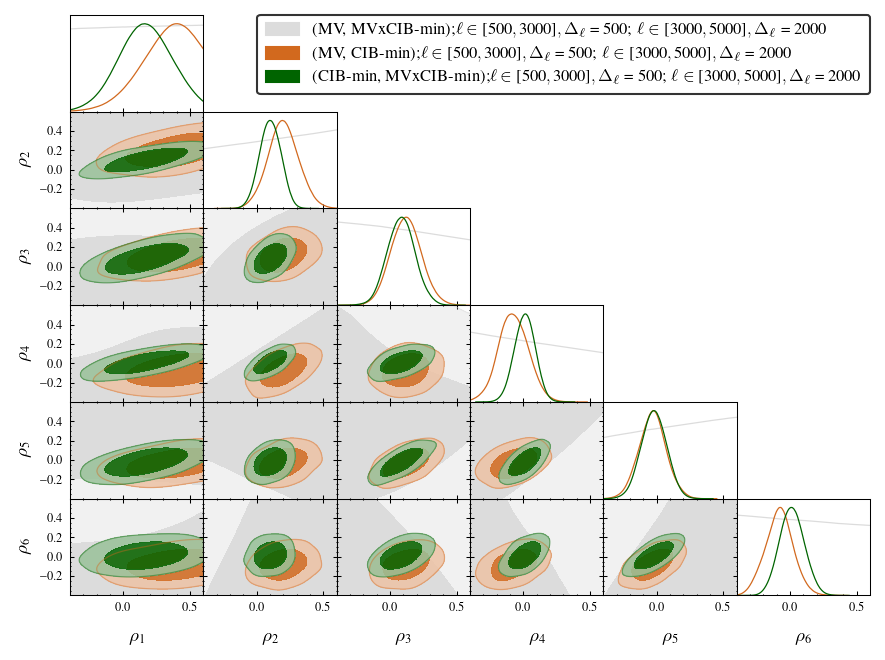

In [64]:
burn_in_fraction = 0.2
rcParams['text.usetex'] = True #False
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.serif'] = ['Computer Modern Roman']

#chain_name = 'tszcibcorr_mv-mvcrosscibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000'
#chain_name = 'tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'

#chain_name = 'tszcibcorr_mv-cibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000'
#chain_name = 'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'

#chain_name = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000'
chain_name = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'

chain_name_arr = [
                  'tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                  'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                  'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                 ]

"""
chain_name_arr = [
                  #'tszcibcorr_mv-cibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000',
                  'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                 ]
"""
"""
chain_name_arr = [
                  'tszcibcorr_cibfree-mvcrosscibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000',
                  'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                 ]
"""
samples_arr_to_plot = []
params_arr_to_plot = []
param_limits_dic = {}
label_arr = []

#which tsz to use
use_odd_even_combs_only = 1

#other variables
tmpiter_key = 'cibmindata_tsz' #'sim_tsz'
#tmpiter_key = 'sim_tsz'
masked_cib_tsz_ps_estimates = 0 ##1
cib_scatter_sigma = None
fit_for_uncorr_cib = 0
fit_for_cib_cal = 0

#
include_beam_chromaticity_arr = [1]# [0, 1] ##1

chain_fd_and_name_arr = []
for tmpiter_key in ['cibmindata_tsz']:#, 'sim_tsz']:
    for include_beam_chromaticity in include_beam_chromaticity_arr: ##[0, 1]:
        for chain_name in chain_name_arr:
            total_bins = int( chain_name.split('_')[2].replace('totalbins', '') )
            #chain_fd_and_name = 'results/chains/%s/%s' %(chain_name, chain_name)
            fd_pref = 'results/chains/20260116_beforeTcalerrors_but_good/'
            if masked_cib_tsz_ps_estimates:
                fd_pref = '%s/masked_cib_tsz_ps_estimates/' %(fd_pref)
            fd_pref = '%s/%s/' %(fd_pref, tmpiter_key)
            if use_odd_even_combs_only:
                fd_pref = '%s/odd_even_crosses_only_no_spire_noise_bias/' %(fd_pref)
            else:
                fd_pref = '%s/all_crosses_with_spire_noise_bias/' %(fd_pref)

            if fit_for_cib_cal:
                fd_pref = '%s/fit_for_cib_cal/' %(fd_pref)
            else:
                fd_pref = '%s/cib_scatter_sigma_%s/' %(fd_pref, cib_scatter_sigma)
            if include_beam_chromaticity:
                fd_pref = '%s/with_beam_chromaticity/' %(fd_pref)

            chain_fd_and_name = '%s/%s/%s' %(fd_pref, chain_name, chain_name)
            print(chain_fd_and_name, '\n')
            chain_fd_and_name_arr.append( chain_fd_and_name )

print( len(chain_fd_and_name_arr) ); ###sys.exit()
    
param_values_dict = {}
for chain_fd_and_name in chain_fd_and_name_arr:
    
    chain_name = chain_fd_and_name.split('/')[-1]
    curr_samples = getdist.mcsamples.loadMCSamples( chain_fd_and_name )
    curr_samples.removeBurn( burn_in_fraction )
    
    chain_labval = chain_name.replace('tszcibcorr_', '')
    chain_labval = chain_labval.replace('mv-cibfree', '(MV, CIB-min);')
    chain_labval = chain_labval.replace('mv-mvcrosscibfree', '(MV, MVxCIB-min);')
    chain_labval = chain_labval.replace('cibfree-mvcrosscibfree', '(CIB-min, MVxCIB-min);')
    chain_labval = chain_labval.replace('_totalbins%s_lbins-' %(total_bins), '')
    if len(chain_fd_and_name_arr) == 3:
        chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000', 
                                           '$\ell \in [500, 5000], \Delta_{\ell} = 500$')
        chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000', 
                                           '$\ell \in [500, 3000], \Delta_{\ell} = 500$; $\ell \in [3000, 5000], \Delta_{\ell} = 2000$' )
    elif len(chain_fd_and_name_arr) == 4:
        chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000', 
                                           '')
        chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000', 
                                           '' )
        if chain_fd_and_name.find('/cibmindata_tsz/')>-1:
            chain_labval = r'%s; tSZ: CIB-min' %(chain_labval)
        elif chain_fd_and_name.find('/sim_tsz/')>-1:
            chain_labval = r'%s; tSZ: Sims' %(chain_labval)

        if chain_fd_and_name.find('/with_beam_chromaticity/')>-1:
            chain_labval = r'%s; Comp-dep beams: True' %(chain_labval)
        
        chain_labval = chain_labval.replace('::', ':').replace(';;', ';')

    chain_labval = r'%s' %(chain_labval)
    label_arr.append( chain_labval )
    
    #change param str
    param_values_dict[chain_name] = {}
    for ppp in curr_samples.paramNames.list():
        if ppp.find('chi')>-1: continue
        currstrval = curr_samples.paramNames.parWithName(ppp).label
        mod_currstrval = currstrval.replace('\\rho_{\\rm tSZxCIB_', '\\rho_{')
        curr_samples.paramNames.parWithName(ppp).label = mod_currstrval
        param_limits_dic[ppp] = [-0.4, 0.6]
        param_values_dict[chain_name][ppp] = curr_samples.getLatex(ppp)
        #print(param_values_dict[chain_labval][ppp]); sys.exit()

    params_to_plot = []
    for binno in range( total_bins ):
        params_to_plot.append( 'rho_tsz_cib_%s' %(binno+1) )
    print(params_to_plot); ##sys.exit()

    '''
    for ppp in params_to_plot:
        g = plots.get_single_plotter(width_inch = 3)
        g.plot_1d( curr_samples, ppp)
        show()
    '''
    print(chain_name, curr_samples.samples.shape)
    samples_arr_to_plot.append( curr_samples )
    params_arr_to_plot.extend( params_to_plot )
    
params_arr_to_plot = np.unique( params_arr_to_plot )
##print( params_arr_to_plot ); sys.exit()

close('all')
clf()
g = plots.get_single_plotter(width_inch = 6)
g.settings.title_limit_fontsize = 20
if len(params_arr_to_plot) == 6:
    g.settings.legend_fontsize = 13
elif len(params_arr_to_plot) == 4:
    g.settings.legend_fontsize = 16

if len(chain_fd_and_name_arr) == 3:
    filled_arr = [True, True, True]
    color_arr = ['gainsboro', 'chocolate', 'darkgreen']
    line_args = None
    legfsval = 12
elif len(chain_fd_and_name_arr) == 4:
    filled_arr = [True, True, False, False]
    color_arr = ['peru', 'darkgreen', 'peru', 'darkgreen']
    line_args=[{'ls':'-', 'lw': 0.5, 'color': 'peru'}, 
               {'ls':'-', 'lw': 0.5, 'color': 'darkgreen'}, 
               {'ls':'--', 'lw': 1., 'color': 'peru'}, 
               {'ls':'--', 'lw': 1., 'color': 'darkgreen'}]
    legfsval = 14

g.triangle_plot(samples_arr_to_plot, params=params_arr_to_plot, 
                contour_colors=color_arr,
                #contour_colors=['silver', 'tab:green', 'peru', 'black'],
                #contour_colors=['peru'],
                framealpha = 1., 
                filled=filled_arr,
                param_limits = param_limits_dic, 
                legend_labels = label_arr,
                legend_loc = 'upper right',
                line_args = line_args, 
                fontsize = 16,
                )
g.settings.legend_fontsize = legfsval
total_subplots = len( g.subplots )
for r in range( total_subplots ):
    for c in range( total_subplots ):
        if c>r:continue
        ax = g.subplots[r,c]
        ax.tick_params('both', length=2, width=0.5, which='major', direction = 'in')
        ax.tick_params('both', length=0.5, width=0.5, which='minor', direction = 'in')
        if r == c: ax.yaxis.set_visible(False) #diagonal
            
##plname = 'rho_tsz_cib.png'
##savefig(plname, dpi = 200.)
show()        

0 0.4 0.25
0 0.2 0.12
0 0.12 0.11
0 -0.07 0.11
0 -0.03 0.1
0 -0.08 0.1
1 0.17 0.2
1 0.102 0.079
1 0.08 0.1
1 0.011 0.078
1 -0.021 0.095
1 0.014 0.093


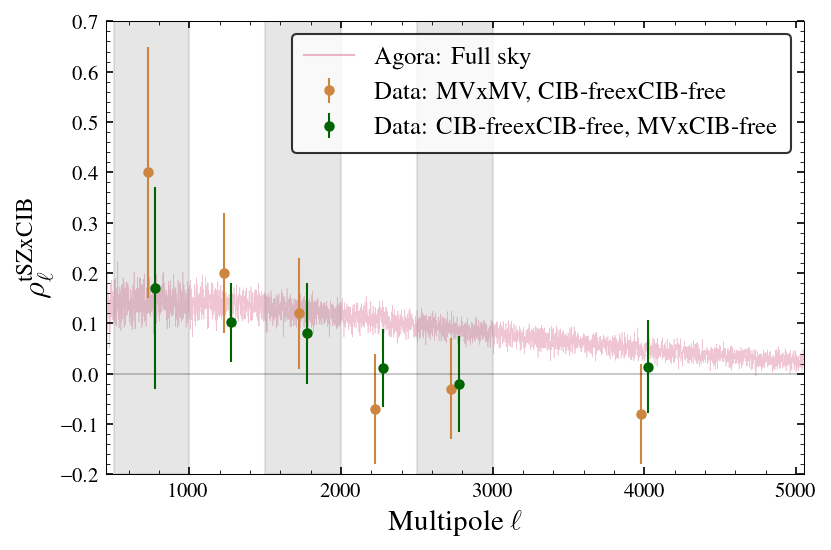

In [77]:
def get_agora_rho_tsz_cib(band1 = 150, band2 = 150, total_sims = 50):
    agora_rho_tsz_cib_arr = []
    for tmpsimno in range(total_sims):
        cl_tsz = sim_ps_dic[tmpsimno][(band1, band2)]['tsz']
        cl_cib = sim_ps_dic[tmpsimno][(band1, band2)]['cib']
        cl_tsz_cib = sim_ps_dic[tmpsimno][(band1, band2)]['tsz_cib']
        if cl_tsz_cib is None or cl_tsz_cib == 'None':
            agora_rho_tsz_cib = np.zeros(len(cl_cib))
        else:
            agora_rho_tsz_cib = abs( cl_tsz_cib / np.sqrt( cl_tsz * cl_cib) )
        agora_rho_tsz_cib_arr.append( agora_rho_tsz_cib )

    agora_rho_tsz_cib_arr = np.asarray( agora_rho_tsz_cib_arr )
    return agora_rho_tsz_cib_arr                  

def get_mdpl2_rho_tsz_cib( band1_for_mdpl2_tsz_cib = 150, band2_for_mdpl2_tsz_cib = 150, mdpl2_cl_fname = 'data/cl_mdpl2_singlepixelsourcemask_radiocibmasked2.0mjy_fromalms_lmax13000.npy'):
    mdpl2_cl_dict = np.load(mdpl2_cl_fname, allow_pickle=True).item()
    mdpl2_cl_cib = mdpl2_cl_dict['cib'][(band1_for_mdpl2_tsz_cib, band1_for_mdpl2_tsz_cib)]
    mdpl2_cl_tsz = mdpl2_cl_dict['tsz'][(band1_for_mdpl2_tsz_cib, band1_for_mdpl2_tsz_cib)]
    mdpl2_cl_tsz_cib = mdpl2_cl_dict['tsz_cib'][(band1_for_mdpl2_tsz_cib, band1_for_mdpl2_tsz_cib)]

    mdpl2_rho_tsz_cib = mdpl2_cl_tsz_cib / np.sqrt( mdpl2_cl_cib * mdpl2_cl_tsz )
    mdpl2_els = np.arange(len(mdpl2_rho_tsz_cib))
    return mdpl2_els, mdpl2_rho_tsz_cib
clf()
agora_color = 'gray'
fsval = 14
"""
agora_rho_tsz_cib_arr = get_agora_rho_tsz_cib(band1 = 90, band2 = 90)
agora_rho_tsz_cib_mean = np.mean(agora_rho_tsz_cib_arr, axis = 0)
# print(agora_rho_tsz_cib_mean)
# agora_rho_tsz_cib_arr = get_agora_rho_tsz_cib()
# agora_rho_tsz_cib_mean = np.mean(agora_rho_tsz_cib_arr, axis = 0)
# print(agora_rho_tsz_cib_mean)
# sys.exit()
for agora_rho_tsz_cib in agora_rho_tsz_cib_arr:
    plot(tmpels, agora_rho_tsz_cib, color = agora_color, alpha = 0.3, lw = 0.5, zorder = -10)
plot(tmpels, agora_rho_tsz_cib_mean, color = agora_color, lw = 1., label = r'Agora')
"""

#reqd_chain_name = 'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'
#reqd_chain_name = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins9_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000'
#reqd_chain_name_arr = np.asarray( list(param_values_dict.keys()) )#[1:]
reqd_chain_name1 = 'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'
reqd_chain_name2 = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'
reqd_chain_name3 = 'tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'

reqd_chain_name_arr = [reqd_chain_name1, reqd_chain_name2] #[reqd_chain_name3]# 
chain_name_dic = {reqd_chain_name1: 'MVxMV, CIB-freexCIB-free', 
                 reqd_chain_name2: 'CIB-freexCIB-free, MVxCIB-free', 
                 reqd_chain_name3: 'MVxMV, MVxCIB-free', }
#color_arr = ['green', 'darkorange']
color_arr = ['peru', 'darkgreen']
#reqd_chain_name_arr = [reqd_chain_name]
xshiftval, xshiftdelta = -25, 50
param_values_dict_for_potting = {}
for tmpcntr, reqd_chain_name in enumerate( reqd_chain_name_arr ):
    ell_bin_str_split = reqd_chain_name.split('lbins-')[1].split('-')
    param_values_dict_for_potting[reqd_chain_name] = {}
    for pppcntr, ppp in enumerate( param_values_dict[reqd_chain_name] ):
        l1l2 = np.asarray( ell_bin_str_split[pppcntr].split('to') ).astype(float)
        l1, l2 = l1l2
        lcen = np.mean(l1l2)
        lerr = (l1l2[1] - l1l2[0])/2
        if pppcntr%2 == 0:
            axvspan(lcen-lerr, lcen+lerr, color = 'gray', alpha = 0.1)
        ppp_val_str = param_values_dict[reqd_chain_name][ppp].split('=')[1]
        if ppp_val_str.find('\pm')>-1:
            ppp_val, ppp_err_val = np.asarray( ppp_val_str.split('\pm') ).astype(float)
        else:
            print(param_values_dict[reqd_chain_name], ppp_val_str); sys.exit()

        print(tmpcntr, ppp_val, ppp_err_val); ##sys.exit()
        param_values_dict_for_potting[reqd_chain_name][ppp] = [ppp_val, ppp_err_val]        
        if pppcntr == 0:
            labval = r'Data: %s' %(chain_name_dic[reqd_chain_name])
        else:
            labval = None
        errorbar(lcen + xshiftval, ppp_val, 
                 #xerr = lerr, 
                 yerr = ppp_err_val, 
                 color = color_arr[tmpcntr],  
                 capsize = 0.,
                marker = 'o', ms = 4.,
                label = labval,
                 ls = 'None',
                )
    xshiftval += xshiftdelta
if (1): #MDPL2 full sky
    mdpl2_color = 'palevioletred'
    mdpl2_els, mdpl2_rho_tsz_cib = get_mdpl2_rho_tsz_cib()
    plot( mdpl2_els, -mdpl2_rho_tsz_cib, color = mdpl2_color, lw = 0.3, zorder = -100, alpha = 0.4)
    plot( [], [], color = mdpl2_color, label = r'Agora: Full sky', alpha = 0.5 )

    """
    mdpl2_els, mdpl2_rho_tsz_cib = get_mdpl2_rho_tsz_cib(band1_for_mdpl2_tsz_cib = 220, band2_for_mdpl2_tsz_cib = 150)
    plot( mdpl2_els, mdpl2_rho_tsz_cib, color = 'sienna', lw = 0.25 )
    """
    
ylim(-0.2, 0.7)
xlim(450., 5050.)
axhline(0., lw= 0.2); axhline(1., lw= 0.2)
xlabel(r'Multipole $\ell$', fontsize = fsval)
ylabel(r'$\rho_{\ell}^{\rm tSZ x CIB}$', fontsize = fsval + 2)
legend(loc = 1, fontsize = 12)
show()



# $\rho_{\rm tSZ x CIB}$ and Difference tests best-fit plots for the paper

results/chains//cibmindata_tsz//odd_even_crosses_only_no_spire_noise_bias//cib_scatter_sigma_None//with_beam_chromaticity//tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000/tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000 

results/chains//cibmindata_tsz//odd_even_crosses_only_no_spire_noise_bias//cib_scatter_sigma_None//with_beam_chromaticity//tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000/tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000 

results/chains//cibmindata_tsz//odd_even_crosses_only_no_spire_noise_bias//cib_scatter_sigma_None//with_beam_chromaticity//tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000/tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to200

<Figure size 900x600 with 0 Axes>

<Figure size 900x675 with 0 Axes>

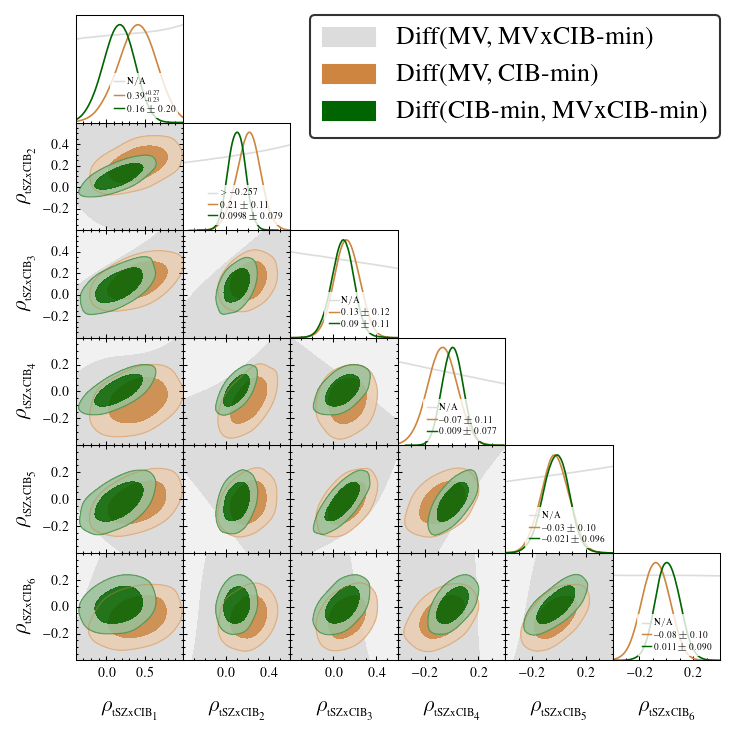

SystemExit: 

In [242]:
def get_mdpl2_rho_tsz_cib( band1_for_mdpl2_tsz_cib = 150, band2_for_mdpl2_tsz_cib = 150, mdpl2_cl_fname = 'data/cl_mdpl2_singlepixelsourcemask_radiocibmasked2.0mjy_fromalms_lmax13000.npy'):
    mdpl2_cl_dict = np.load(mdpl2_cl_fname, allow_pickle=True).item()
    mdpl2_cl_cib = mdpl2_cl_dict['cib'][(band1_for_mdpl2_tsz_cib, band1_for_mdpl2_tsz_cib)]
    mdpl2_cl_tsz = mdpl2_cl_dict['tsz'][(band1_for_mdpl2_tsz_cib, band1_for_mdpl2_tsz_cib)]
    mdpl2_cl_tsz_cib = mdpl2_cl_dict['tsz_cib'][(band1_for_mdpl2_tsz_cib, band1_for_mdpl2_tsz_cib)]

    mdpl2_rho_tsz_cib = mdpl2_cl_tsz_cib / np.sqrt( mdpl2_cl_cib * mdpl2_cl_tsz )
    mdpl2_els = np.arange(len(mdpl2_rho_tsz_cib))
    return mdpl2_els, mdpl2_rho_tsz_cib


if (1): #get samples and make corner plot
    burn_in_fraction = 0.3
    rcParams['text.usetex'] = True #False
    #rcParams['font.family'] = 'sans-serif'
    #rcParams['font.serif'] = ['Computer Modern Roman']

    chain_name_arr = [
                      'tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                      'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                      'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000',
                     ]


    samples_arr_to_plot = []
    params_arr_to_plot = []
    param_limits_dic = {}
    label_arr = []

    #which tsz to use
    use_odd_even_combs_only = 1

    #other variables
    tmpiter_key = 'cibmindata_tsz' #'sim_tsz'
    masked_cib_tsz_ps_estimates = 0 ##1
    cib_scatter_sigma = None
    fit_for_uncorr_cib = 0
    fit_for_cib_cal = 0

    #
    include_beam_chromaticity_arr = [1]# [0, 1] ##1

    chain_fd_and_name_arr = []
    for tmpiter_key in ['cibmindata_tsz']:#, 'sim_tsz']:
        for include_beam_chromaticity in include_beam_chromaticity_arr: ##[0, 1]:
            for chain_name in chain_name_arr:
                total_bins = int( chain_name.split('_')[2].replace('totalbins', '') )
                #chain_fd_and_name = 'results/chains/%s/%s' %(chain_name, chain_name)
                #fd_pref = 'results/chains/20260116_beforeTcalerrors_but_good/'
                fd_pref = 'results/chains/'
                if masked_cib_tsz_ps_estimates:
                    fd_pref = '%s/masked_cib_tsz_ps_estimates/' %(fd_pref)
                fd_pref = '%s/%s/' %(fd_pref, tmpiter_key)
                if use_odd_even_combs_only:
                    fd_pref = '%s/odd_even_crosses_only_no_spire_noise_bias/' %(fd_pref)
                else:
                    fd_pref = '%s/all_crosses_with_spire_noise_bias/' %(fd_pref)

                if fit_for_cib_cal:
                    fd_pref = '%s/fit_for_cib_cal/' %(fd_pref)
                else:
                    fd_pref = '%s/cib_scatter_sigma_%s/' %(fd_pref, cib_scatter_sigma)
                if include_beam_chromaticity:
                    fd_pref = '%s/with_beam_chromaticity/' %(fd_pref)

                chain_fd_and_name = '%s/%s/%s' %(fd_pref, chain_name, chain_name)
                print(chain_fd_and_name, '\n')
                chain_fd_and_name_arr.append( chain_fd_and_name )

    print( len(chain_fd_and_name_arr) ); ###sys.exit()

    param_values_dict = {}
    param_cov_corr_dic = {}
    for chain_fd_and_name in chain_fd_and_name_arr:

        chain_name = chain_fd_and_name.split('/')[-1]
        curr_samples = getdist.mcsamples.loadMCSamples( chain_fd_and_name )
        curr_samples.removeBurn( burn_in_fraction )

        chain_labval = chain_name.replace('tszcibcorr_', '')
        chain_labval = chain_labval.replace('mv-cibfree', '(MV, CIB-min);')
        chain_labval = chain_labval.replace('mv-mvcrosscibfree', '(MV, MVxCIB-min);')
        chain_labval = chain_labval.replace('cibfree-mvcrosscibfree', '(CIB-min, MVxCIB-min);')
        chain_labval = chain_labval.replace('_totalbins%s_lbins-' %(total_bins), '')
        if len(chain_fd_and_name_arr) == 3:
            chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000', 
                                               '$\ell \in [500, 5000], \Delta_{\ell} = 500$')
            chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000', 
                                               '$\ell \in [500, 3000], \Delta_{\ell} = 500$; $\ell \in [3000, 5000], \Delta_{\ell} = 2000$' )
        elif len(chain_fd_and_name_arr) == 4:
            chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to3500-3500to4000-4000to4500-4500to5000', 
                                               '')
            chain_labval = chain_labval.replace('500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000', 
                                               '' )
            if chain_fd_and_name.find('/cibmindata_tsz/')>-1:
                chain_labval = r'%s; tSZ: CIB-min' %(chain_labval)
            elif chain_fd_and_name.find('/sim_tsz/')>-1:
                chain_labval = r'%s; tSZ: Sims' %(chain_labval)

            if chain_fd_and_name.find('/with_beam_chromaticity/')>-1:
                chain_labval = r'%s; Comp-dep beams: True' %(chain_labval)

            chain_labval = chain_labval.replace('::', ':').replace(';;', ';')

        chain_labval = r'%s' %(chain_labval)
        if (1):
            chain_labval = r'Diff%s' %(chain_labval.split(';')[0])
        label_arr.append( chain_labval )

        #change param str
        param_values_dict[chain_name] = {}
        for pcntr, ppp in enumerate( curr_samples.paramNames.list() ):
            if ppp.find('chi')>-1: continue
            currstrval = curr_samples.paramNames.parWithName(ppp).label
            ##mod_currstrval = currstrval.replace('\\rho_{\\rm tSZxCIB_', '\\rho_{')
            mod_currstrval = currstrval.replace('\\rho_{\\rm tSZxCIB_', '\\rho_{_{\\rm tSZxCIB_')
            mod_currstrval = '%s}' %(mod_currstrval)
            ##print(mod_currstrval); sys.exit()
            curr_samples.paramNames.parWithName(ppp).label = mod_currstrval
            if pcntr == 0:
                param_limits_dic[ppp] = [-0.4, 1.]
            elif pcntr in [1, 2]:
                param_limits_dic[ppp] = [-0.4, 0.6]
            else:
                param_limits_dic[ppp] = [-0.4, 0.4]
            param_values_dict[chain_name][ppp] = curr_samples.getLatex(ppp)
            #print(param_values_dict[chain_labval][ppp]); sys.exit()

        params_to_plot = []
        for binno in range( total_bins ):
            params_to_plot.append( 'rho_tsz_cib_%s' %(binno+1) )
        ##print(params_to_plot); ##sys.exit()

        print(chain_name, curr_samples.samples.shape)

        curr_cov = tools.get_param_cov_mat_from_getdist(curr_samples, params_to_plot)
        curr_corr = tools.corr_from_cov(curr_cov)
        param_cov_corr_dic[chain_name] = [curr_cov, curr_corr]
        
        samples_arr_to_plot.append( curr_samples )
        params_arr_to_plot.extend( params_to_plot )
        
    params_arr_to_plot = np.unique( params_arr_to_plot )
    ##print( params_arr_to_plot ); sys.exit()

    close('all')
    clf()
    g = plots.get_single_plotter(width_inch = 6)
    legfsval = 17.8
    figsize = 5. #4.8
    g = plots.get_subplot_plotter(width_inch=figsize)
    g.settings.title_limit_fontsize = 20
    g.settings.legend_fontsize = legfsval
    g.settings.axes_fontsize = 12
    g.settings.axes_labelsize = 16

    filled_arr = [True, True, True]
    color_arr = ['gainsboro', 'peru', 'darkgreen']
    line_args = None
    diagonal_errors_fsval = 4.5
    diagonal_errors_legloc = 4
    line_args=[{'ls':'-', 'lw': 0.8, 'color': color_arr[0]}, 
               {'ls':'-', 'lw': 0.8, 'color': color_arr[1]}, 
               {'ls':'-', 'lw': 0.8, 'color': color_arr[2]}, 
              ]
    legloc = 'upper right'

    clf()
    g.triangle_plot(samples_arr_to_plot, params=params_arr_to_plot, filled=filled_arr, \
                    param_limits = param_limits_dic, \
                    contour_colors=color_arr, 
                    framealpha = 1., 
                    legend_labels = label_arr, legend_loc = legloc, 
                    figsize = figsize,
                    line_args = line_args,
                    #fontsize = 20, 
                    #ls = ls_arr, 
                    #line_args = line_args, 
                    #analysis_settings={'ignore_rows': 0.5},
                    #contour_ls = ls_arr, contour_lw = lw_arr, legend_ncol = len(param_names), param_limits = param_limits_dic, 
                    )

    #get constraints
    constraints_dic, constraints_table, colors_table, col_labels = tools.get_constraints_table(params_arr_to_plot, samples_arr_to_plot, color_arr)        
    ##print(constraints_table); sys.exit()
    g = tools.write_errors_in_diagonal_posteriors(g, params_arr_to_plot, color_arr, constraints_dic, legfsval = diagonal_errors_fsval, ncol=1, legloc = diagonal_errors_legloc)
    g = tools.mark_axlines(g, params_arr_to_plot)
    
    
    
    plname = 'plots/rho_tsz_cib_corner_6bins.pdf'
    ###savefig(plname, dpi = 200.)
    show(); sys.exit()



0 0.39 0.25
0 0.21 0.11
0 0.13 0.12
0 -0.07 0.11
0 -0.03 0.1
0 -0.08 0.1
Diff(MV, CIB-free) SNR of tSZ x CIB = 3.0426444353863333 [[1.         0.43350976 0.46572934 0.32724817 0.39051415 0.26459778]
 [0.43350976 1.         0.28042807 0.52993562 0.26288907 0.20676955]
 [0.46572934 0.28042807 1.         0.16046714 0.49192777 0.32568103]
 [0.32724817 0.52993562 0.16046714 1.         0.40313332 0.4004128 ]
 [0.39051415 0.26288907 0.49192777 0.40313332 1.         0.52480597]
 [0.26459778 0.20676955 0.32568103 0.4004128  0.52480597 1.        ]]
1 0.16 0.2
1 0.0998 0.079
1 0.09 0.11
1 0.009 0.077
1 -0.021 0.096
1 0.011 0.09
Diff(CIB-free, MVxCIB-free) SNR of tSZ x CIB = 1.9811528672058436 [[1.         0.68100583 0.58504462 0.67466231 0.54203943 0.22335401]
 [0.68100583 1.         0.44599559 0.60930506 0.31290212 0.13110633]
 [0.58504462 0.44599559 1.         0.48708036 0.74142576 0.47267932]
 [0.67466231 0.60930506 0.48708036 1.         0.65120476 0.51438966]
 [0.54203943 0.31290212 0.7414257

<Figure size 900x600 with 0 Axes>

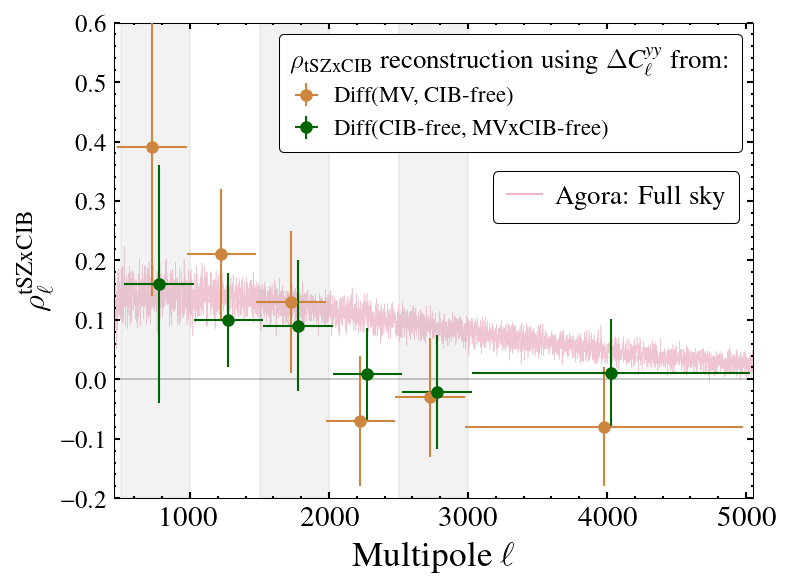

In [253]:
###################################################################################################
###################################################################################################
###################################################################################################

#make rho_tsz_cib vs \ell plot
clf()
fig = figure(figsize = (5.5, 4.2))
fsval = 14
reqd_chain_name1 = 'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'
reqd_chain_name2 = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'
reqd_chain_name3 = 'tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000'

reqd_chain_name_arr = [reqd_chain_name1, reqd_chain_name2] #[reqd_chain_name3]# 
chain_name_dic = {reqd_chain_name1: r'Diff(MV, CIB-free)', 
                 reqd_chain_name2: r'Diff(CIB-free, MVxCIB-free)', 
                 reqd_chain_name3: r'Diff(MV, MVxCIB-free)', 
                 }
#color_arr = ['green', 'darkorange']
color_arr = ['peru', 'darkgreen']
#reqd_chain_name_arr = [reqd_chain_name]
xshiftval, xshiftdelta = -25, 50
param_values_dict_for_potting = {}
ax = subplot(111)
for tmpcntr, reqd_chain_name in enumerate( reqd_chain_name_arr ):
    ell_bin_str_split = reqd_chain_name.split('lbins-')[1].split('-')
    param_values_dict_for_potting[reqd_chain_name] = {}
    for pppcntr, ppp in enumerate( param_values_dict[reqd_chain_name] ):
        l1l2 = np.asarray( ell_bin_str_split[pppcntr].split('to') ).astype(float)
        l1, l2 = l1l2
        lcen = np.mean(l1l2)
        lerr = (l1l2[1] - l1l2[0])/2
        if pppcntr%2 == 0:
            axvspan(lcen-lerr, lcen+lerr, color = 'silver', alpha = 0.1)
        ppp_val_str = param_values_dict[reqd_chain_name][ppp].split('=')[1]
        if ppp_val_str.find('\pm')>-1:
            ppp_val, ppp_err_val = np.asarray( ppp_val_str.split('\pm') ).astype(float)
        elif ppp_val_str.find('^')>-1:
            tmpsplit = ppp_val_str.split('^{')
            tmpsplit2 = ppp_val_str.split('}_{-')
            ppp_val = float( tmpsplit[0] )
            ppp_err_high_val = float( tmpsplit[1].split('}')[0] )
            ppp_err_low_val = float( tmpsplit2[1].split('}')[0] )
            ppp_err_val = (ppp_err_high_val+ppp_err_low_val)/2.
            #print(param_values_dict[reqd_chain_name], ppp_val, ppp_err_high_val, ppp_err_low_val, ppp_val_str); sys.exit()
        else:
            print(param_values_dict[reqd_chain_name], ppp_val_str); sys.exit()

        print(tmpcntr, ppp_val, ppp_err_val); ##sys.exit()
        param_values_dict_for_potting[reqd_chain_name][ppp] = [ppp_val, ppp_err_val]        
        if pppcntr == 0:
            labval = r'%s' %(chain_name_dic[reqd_chain_name])
        else:
            labval = None
        errorbar(lcen + xshiftval, ppp_val, 
                 xerr = lerr, 
                 yerr = ppp_err_val, 
                 color = color_arr[tmpcntr],  
                 capsize = 0.,
                marker = 'o', ms = 5.,
                label = labval,
                 ls = 'None',
                 zorder = 100
                )
        
    if (1): #get SNR of rho_tsz_cib
        data_vector = np.asarray( list(param_values_dict_for_potting[reqd_chain_name].values()) )[:,0]
        curr_cov, curr_corr = param_cov_corr_dic[reqd_chain_name]
        curr_cov_inv = np.linalg.inv(curr_cov)    
        chi_sq_val = np.dot(data_vector, np.dot(data_vector, curr_cov_inv))
        snr = np.sqrt( chi_sq_val )
        print(chain_name_dic[reqd_chain_name], 'SNR of tSZ x CIB = %s' %(snr), curr_corr)

    xshiftval += xshiftdelta
if (1): #MDPL2 full sky
    mdpl2_color = 'palevioletred'
    mdpl2_els, mdpl2_rho_tsz_cib = get_mdpl2_rho_tsz_cib()
    plot( mdpl2_els, -mdpl2_rho_tsz_cib, color = mdpl2_color, lw = 0.3, zorder = -100, alpha = 0.4)
    plot( [], [], color = mdpl2_color, label = r'Agora: Full sky', alpha = 0.5 )

ax = format_axis(ax, fsval, fsval-2)    
ylim(-0.2, 0.6)
xlim(450., 5050.)
axhline(0., lw= 0.2); axhline(1., lw= 0.2)
xlabel(r'Multipole $\ell$', fontsize = fsval+3)
ylabel(r'$\rho_{\ell}^{\rm tSZ x CIB}$', fontsize = fsval + 2)
#legend(loc = 1, fontsize = 12)
handles, labels = ax.get_legend_handles_labels()
handles = np.asarray( handles )
labels = np.asarray( labels )
total_inds = np.arange(len(labels))
inds1 = [1, 2]
legfsval = fsval-3
xloc = 1.
inds2 = list( set(total_inds) - set(inds1) )

yloc = 0.72
leg1 = ax.legend(handles[inds1], labels[inds1],
                 # bbox_to_anchor = (xloc, yloc), loc = 4, 
                 loc = 1,
                 fontsize = legfsval, 
                 title = r'$\rho_{\rm tSZ x CIB}$ reconstruction using $\Delta C_{\ell}^{yy}$ from:',
                 title_fontsize = legfsval + 2,
                 ncol = 1, 
                 handletextpad = 0.5, 
                 columnspacing = 0.5, 
                 handlelength = 1.4, 
                 numpoints = 1, 
                 framealpha = 1.)
#leg1.get_frame().set_edgecolor('whitesmoke')
leg1.get_frame().set_linewidth(.5)
leg1._legend_box.align = 'left'
if len(inds2)>0:
    ax.add_artist(leg1)
    leg2 = ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (1., .55), loc = 4, fontsize = legfsval+2, ncol = 1, handletextpad = 0.5, columnspacing = 0.3, handlelength = 1.3, numpoints = 1, framealpha = 1.)
    #leg2.get_frame().set_edgecolor('whitesmoke')
    leg2.get_frame().set_linewidth(.5)
    leg2.set_zorder(0)
plname = 'plots/rho_tsz_cib.pdf'
###savefig(plname, dpi = 200.)
show()


(9, 9) (9, 9) (9, 9) (9, 9) (9, 9) (9, 9)


<Figure size 900x600 with 0 Axes>

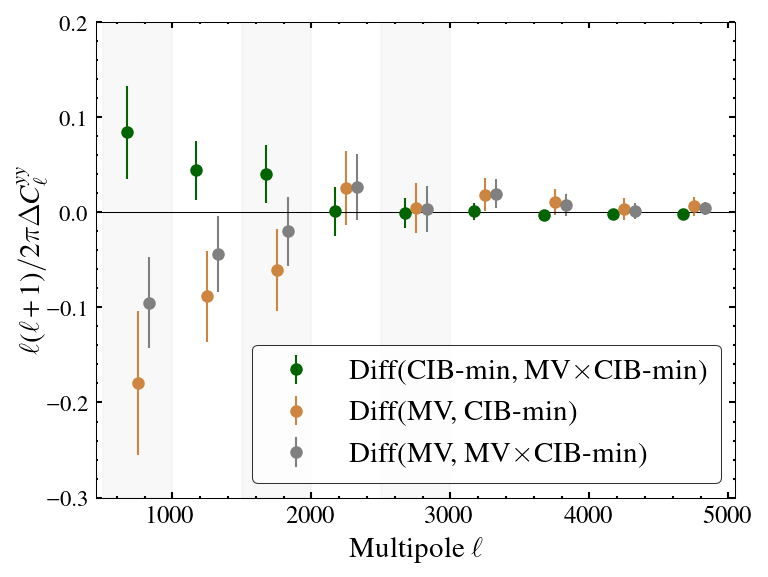

SystemExit: 

In [233]:


###################################################################################################
###################################################################################################
###################################################################################################

#samples
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()
##print(res_dic.keys()); sys.exit()
op_ps_1d_dic = res_dic['op_ps_1d_dic']
full_stat_cov = res_dic['full_stat_cov']
full_sys_cov_dic = res_dic['full_sys_cov_dic']
##print(full_sys_cov_dic.keys()); sys.exit()
m1m2_arr = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')]
tmpels = res_dic[m1m2_arr[0]]['els']

final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                full_sys_cov_dic['cmb_withspiretcalerror'] + \
                full_sys_cov_dic['ksz'] + \
                full_sys_cov_dic['cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_tcal_tweaked']

            
full_cov = full_stat_cov + final_full_sys_cov

#sim tszxCIB estimates
masked_cib_tsz_ps_estimates = False #True #False
if masked_cib_tsz_ps_estimates:
    sim_tsz_cib_estimate_fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope_sim_tszcib_estimates.npy'
else:
    sim_tsz_cib_estimate_fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope_sim_tszcib_estimates_nomasking.npy'
sim_tsz_cib_estimate_dic = np.load( sim_tsz_cib_estimate_fname, allow_pickle=True).item()
#print(sim_tsz_cib_estimate_dic.keys()); sys.exit()

total_sims_for_tsz_cib = 50
sim_ps_dic = sim_tsz_cib_estimate_dic['sim_ps_dic']
bands = sim_tsz_cib_estimate_dic['bands']
ilc_1d_weights_dic = sim_tsz_cib_estimate_dic['ilc_1d_weights_dic']
#cl_yy_fromcibmindata = sim_tsz_cib_estimate_dic['cl_yy_fromcibmindata']
tmpiter_key = 'cibmindata_tsz' #'sim_tsz'
#tmpiter_key = 'sim_tsz' #'sim_tsz'
use_odd_even_combs_only = True
wl_dic = {}
for ilc_keyname in ['ymv', 'ycibfree']:
    wl_arr = []
    els = ilc_1d_weights_dic[ilc_keyname]['els']
    for freq in ilc_1d_weights_dic[ilc_keyname]:
        if freq == 'els': continue
        ###print(freq)
        binned_weights = ilc_1d_weights_dic[ilc_keyname][freq]                
        wl = np.interp( tmpels, els, binned_weights )
        wl_arr.append( wl )
    wl_arr = np.asarray(wl_arr)
    wl_dic[ilc_keyname] = wl_arr


linds = np.arange(len(tmpels))


ilc_keyname1, ilc_keyname2, ilc_keyname3 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
tmpels = tmpels[linds]
curr_dl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
d1_undesired_comp = res_dic[ilc_keyname1]['sim'][linds]
d2_undesired_comp = res_dic[ilc_keyname2]['sim'][linds]
d3_undesired_comp = res_dic[ilc_keyname3]['sim'][linds]
d1 = res_dic[ilc_keyname1]['data_final_odd_even_combs_only'][linds]
d2 = res_dic[ilc_keyname2]['data_final_odd_even_combs_only'][linds]
d3 = res_dic[ilc_keyname3]['data_final_odd_even_combs_only'][linds]

reclen = len(d1)
curr_cov_11 = full_cov[:reclen, :reclen]
curr_cov_22 = full_cov[reclen:2*reclen, reclen:2*reclen]
curr_cov_33 = full_cov[2*reclen:, 2*reclen:]
curr_cov_12 = full_cov[reclen:2*reclen,:reclen]
curr_cov_13 = full_cov[2*reclen:,:reclen]
curr_cov_23 = full_cov[2*reclen:,reclen:2*reclen]
print(curr_cov_11.shape, curr_cov_22.shape, curr_cov_33.shape, curr_cov_12.shape, curr_cov_13.shape, curr_cov_23.shape)

if (0):
    which_sim = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits'
    include_beam_chromaticity = 1
    total_samples = 2 #10 ##100#00
    pl_dic = {}
    for pliter in range(2):
        pl_dic[pliter] = {}
        for tmpiter in range(3):
            #if tmpiter == 0: continue
            print('\ntmpiter = %s' %(tmpiter))
            if tmpiter == 1: #d1, d2
                #data
                curr_diff_vector = d1-d2
                curr_diff_cov = curr_cov_11 + curr_cov_22 - 2 * curr_cov_12

                #sims
                sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim) - d1_undesired_comp
                sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim) - d2_undesired_comp
                m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree')
                
                
                title_val = r'Diff(MV, CIB-min)'
                key_for_sima, key_for_simb = ilc_keyname1, ilc_keyname2
                undesired_comp_for_sima, undesired_comp_for_simb = d1_undesired_comp, d2_undesired_comp
                reqd_chain_name = 'tszcibcorr_mv-cibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000' %()
            elif tmpiter == 2: #d1, d3
                curr_diff_vector = d1-d3
                curr_diff_cov = curr_cov_11 + curr_cov_33 - 2 * curr_cov_13

                #sims
                sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim) - d1_undesired_comp
                sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim) - d3_undesired_comp
                title_val = r'Diff(MV, MVxCIB-min)'
                m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ymv')
                key_for_sima, key_for_simb = ilc_keyname1, ilc_keyname3
                undesired_comp_for_sima, undesired_comp_for_simb = d1_undesired_comp, d3_undesired_comp
                reqd_chain_name = 'tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000' %()
                
            elif tmpiter == 0: #d2, d3
                curr_diff_vector = d2-d3
                curr_diff_cov = curr_cov_22 + curr_cov_33 - 2 * curr_cov_23

                #sims
                sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim) - d2_undesired_comp
                sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim) - d3_undesired_comp
                title_val = r'Diff(CIB-min, MVxCIB-min)'
                m1, m2 = ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
                key_for_sima, key_for_simb = ilc_keyname2, ilc_keyname3
                undesired_comp_for_sima, undesired_comp_for_simb = d2_undesired_comp, d3_undesired_comp
                reqd_chain_name = 'tszcibcorr_cibfree-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000' %()
                

            if which_sim == 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits': #add sim tSZ/CIB here


                if pliter == 0:
                    reqd_tsz_cib_dic = {(500, 1000): 0., 
                                        (1000, 1500): 0., 
                                        (1500, 2000): 0., 
                                        (2000, 2500): 0., 
                                        (2500, 3000): 0., 
                                        (3000, 5000): 0., 
                                       }        
                elif pliter == 1:
                    
                    reqd_tsz_cib_dic = {(500, 1000): 0.17, 
                                        (1000, 1500): 0.102, 
                                        (1500, 2000): 0.08, 
                                        (2000, 2500): 0.011, 
                                        (2500, 3000): -0.021, 
                                        (3000, 5000): 0.014, 
                                       }        

                reqd_tsz_cib_dic_samples_dic = {}
                rho_tsz_cib_min, rho_tsz_cib_max = -1, 1
                if reqd_chain_name in param_values_dict_for_potting:                    
                    assert len(reqd_tsz_cib_dic) == len(param_values_dict_for_potting[reqd_chain_name])
                    for pcntr, (l1l2, ppp) in enumerate( zip(reqd_tsz_cib_dic, param_values_dict_for_potting[reqd_chain_name]) ):
                        pval, pval_err = param_values_dict_for_potting[reqd_chain_name][ppp]
                        rho_tsz_cib_samples = np.random.standard_normal( total_samples ) * pval_err + pval
                        rho_tsz_cib_samples[rho_tsz_cib_samples>rho_tsz_cib_max] = rho_tsz_cib_max
                        rho_tsz_cib_samples[rho_tsz_cib_samples<rho_tsz_cib_min] = rho_tsz_cib_min
                        if (0):
                            hist(rho_tsz_cib_samples, bins = np.arange(rho_tsz_cib_min, rho_tsz_cib_max, 0.1)); 
                            axvline(pval); axvline(pval-pval_err, ls = '--'); axvline(pval+pval_err, ls = '--')
                            show(); sys.exit()

                        reqd_tsz_cib_dic[l1l2] = pval
                        reqd_tsz_cib_dic_samples_dic[l1l2] = rho_tsz_cib_samples
                else:
                    for l1l2 in reqd_tsz_cib_dic:
                        reqd_tsz_cib_dic_samples_dic[l1l2] = np.zeros(total_samples)
                        reqd_tsz_cib_dic[l1l2] = 0.

                sim_diff_sample_arr = []
                for sampleno in range( total_samples ):
                    print(sampleno, end = ' ')

                    sa_arr = tools.get_sim_arrary(res_dic, key_for_sima, which_sim) - undesired_comp_for_sima
                    sb_arr = tools.get_sim_arrary(res_dic, key_for_simb, which_sim) - undesired_comp_for_simb
                    for l1l2 in reqd_tsz_cib_dic:
                        reqd_tsz_cib = reqd_tsz_cib_dic_samples_dic[l1l2][sampleno]
                        l1, l2 = l1l2
                        curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]
                        ##print(reqd_tsz_cib, l1, l2); sys.exit()#, curr_rho_tsz_cib_linds)
                        sa_arr, sb_arr, res_cib_a_arr, res_cib_b_arr = tools.account_for_tsz_cib_in_sims(reqd_tsz_cib, sa_arr, sb_arr, 
                                                                           sim_ps_dic, 
                                                                           bands, 
                                                                           wl_dic, 
                                                                           m1, m2,
                                                                           sim_tsz_cib_estimate_dic,
                                                                           total_sims_for_tsz_cib = total_sims_for_tsz_cib, 
                                                                           sim_or_data_tsz = tmpiter_key,
                                                                           reqd_linds = curr_rho_tsz_cib_linds, 
                                                                           include_beam_chromaticity = include_beam_chromaticity, 
                                                                          )

                    curr_diff_vector_sim_arr = sa_arr - sb_arr
                    curr_diff_vector_sim_arr = curr_diff_vector_sim_arr[25:]
                    curr_diff_vector_sim_mean = np.mean(curr_diff_vector_sim_arr, axis = 0)
                    sim_diff_sample_arr.append( curr_diff_vector_sim_mean )
                pl_dic[pliter][tmpiter] = [reqd_tsz_cib_dic, curr_diff_vector, sim_diff_sample_arr, curr_diff_cov]
                print('\n')
    sys.exit()

#data-only plot    
clf()
fig = figure(figsize = (5.5, 4.2))
fsval = 14
xmin, xmax = 450, 5050
ymin, ymax = -0.3, 0.2
msval = 5.
tmpiter_to_plot_dic = {0: [r'Diff(CIB-min, MV$\times$CIB-min)', 'darkgreen'], 
                       1: [r'Diff(MV, CIB-min)', 'peru'], 
                       2: [r'Diff(MV, MV$\times$CIB-min)', 'gray'],
                      }
pliter = 1
ax = subplot(111)
xshiftval, xdeltashiftval = -80, 80
for tmpiter in tmpiter_to_plot_dic:
    reqd_tsz_cib_dic, curr_diff_vector, curr_diff_vector_sim_arr, curr_diff_cov = pl_dic[pliter][tmpiter]
    curr_diff_vector_err = np.sqrt( np.diag(curr_diff_cov) )
    
    labval, colorval = tmpiter_to_plot_dic[tmpiter]
    errorbar( tmpels + xshiftval, curr_dl_fac * curr_diff_vector, 
             yerr = curr_dl_fac * curr_diff_vector_err, 
             color = colorval, marker = 'o', 
             ls = 'None',
             ms = msval, 
             label = labval, 
             capsize = 0.,
            )
    xshiftval += xdeltashiftval
        
xlim(xmin, xmax); ylim(ymin, ymax)
if (1):
    for bincntr, l1l2 in enumerate( sorted(reqd_tsz_cib_dic) ):
        l1, l2 = l1l2
        lcen = np.mean(l1l2)
        lerr = (l1l2[1] - l1l2[0])/2
        if bincntr%2 == 0:
            axvspan(lcen-lerr, lcen+lerr, color = 'silver', alpha = 0.1)
    
ax = format_axis(ax, fsval-2, fsval-3)
axhline(0., lw = 0.5); ##show(); #sys.exit()
xlabel(r'Multipole $\ell$', fontsize = fsval)
ylabel(r'$\ell (\ell+1)/2\pi \Delta C_{\ell}^{yy}$', fontsize = fsval, labelpad = 0.)
legfsval = fsval
leg = legend(loc = 4, fontsize = legfsval,                 
     #title = r'$\Delta C_{\ell}^{yy}$:', title_fontsize = legfsval + 2,
    )
leg.get_frame().set_linewidth(.5)
leg._legend_box.align = 'left'

plname = 'plots/ilc_yy_difference_spectra.pdf'
savefig(plname, dpi = 200.)
show()
sys.exit()

#data and sims
clf()
if (1):
    reqd_iter_to_plot = [1]
    figure( figsize = (8., 3.2))
    subplots_adjust(wspace = 0.02, hspace = 0.02)
    sbpl_for_xlab = [1, 2, 3]
    sbpl_for_ylab = [1]    
    tr, tc = 1, len(pl_dic[pliter])
    fsval = 12
else:
    fsval = 14
    reqd_iter_to_plot = [0, 1]
    figure( figsize = (10., 6.))
    subplots_adjust(wspace = 0.02, hspace = 0.02)
    sbpl_for_xlab = [4, 5, 6]
    sbpl_for_ylab = [1, 4]    
    tr, tc = 2, len(pl_dic[pliter])
xmin, xmax = 450, 5050
ymin, ymax = -0.22, 0.22
msval = 5.
sbpl = 1
tmpiter_to_plot_dic = {0: [r'Diff(CIB-min, MV$\times$CIB-min)', 'darkgreen'], 
                       1: [r'Diff(MV, CIB-min)', 'peru'], 
                       2: [r'Diff(MV, MV$\times$CIB-min)', 'steelblue'], 
                      }
simcolor = 'gray'
for pliter in reqd_iter_to_plot:
    for tmpiter in pl_dic[pliter]:
        reqd_tsz_cib_dic, curr_diff_vector, curr_diff_vector_sim_arr, curr_diff_cov = pl_dic[pliter][tmpiter]
        curr_diff_vector_err = np.sqrt( np.diag(curr_diff_cov) )
        ax = subplot(tr, tc, sbpl)
        for simcntr, cl_ in enumerate( curr_diff_vector_sim_arr ):
            plot( tmpels, curr_dl_fac * cl_, color = simcolor, lw = 0.5, alpha = 0.2)

        labval, colorval = tmpiter_to_plot_dic[tmpiter]
        errorbar( tmpels, curr_dl_fac * curr_diff_vector, 
                 yerr = curr_dl_fac * curr_diff_vector_err, 
                 color = colorval, marker = 'o', 
                 ls = 'None',
                 ms = msval, 
                 capsize = 0.,
                )
            
        xlim(xmin, xmax); ylim(ymin, ymax)
        #ax = make_ver_shades(ax, el_)
        if (1):
            for bincntr, l1l2 in enumerate( sorted(reqd_tsz_cib_dic) ):
                l1, l2 = l1l2
                lcen = np.mean(l1l2)
                lerr = (l1l2[1] - l1l2[0])/2
                if bincntr%2 == 0:
                    axvspan(lcen-lerr, lcen+lerr, color = 'silver', alpha = 0.2)
            
        ax = format_axis(ax, fsval-2, fsval-2)
        axhline(0., lw = 0.5); ##show(); #sys.exit()

        if sbpl in sbpl_for_xlab:
            xlabel(r'Multipole $\ell$', fontsize = fsval)
        else:
            setp(ax.get_xticklabels(), visible=False)
        if sbpl in sbpl_for_ylab:
            ylabel(r'$\Delta D_{\ell}^{yy}$', fontsize = fsval, labelpad = 0.)
        else:
            setp(ax.get_yticklabels(), visible=False)
        title(r'%s' %(labval), fontsize = fsval)
        sbpl += 1

show()
sys.exit()

In [202]:
print( reqd_chain_name in param_values_dict_for_potting.keys() )
print( reqd_chain_name )

False
tszcibcorr_mv-mvcrosscibfree_totalbins6_lbins-500to1000-1000to1500-1500to2000-2000to2500-2500to3000-3000to5000


# get tSZxCIB for each ILC based on the above results

In [49]:
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()
op_ps_1d_dic = res_dic['op_ps_1d_dic']
full_stat_cov = res_dic['full_stat_cov']
full_sys_cov_dic = res_dic['full_sys_cov_dic']
m1m2_arr = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')]
tmpels = res_dic[m1m2_arr[0]]['els']

final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                full_sys_cov_dic['cmb_withspiretcalerror'] + \
                full_sys_cov_dic['ksz']
            
full_cov = full_stat_cov + final_full_sys_cov

#sim tszxCIB estimates
masked_cib_tsz_ps_estimates = False #True #False
if masked_cib_tsz_ps_estimates:
    sim_tsz_cib_estimate_fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope_sim_tszcib_estimates.npy'
else:
    sim_tsz_cib_estimate_fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope_sim_tszcib_estimates_nomasking.npy'
sim_tsz_cib_estimate_dic = np.load( sim_tsz_cib_estimate_fname, allow_pickle=True).item()
#print(sim_tsz_cib_estimate_dic.keys()); sys.exit()

total_sims_for_tsz_cib = 50
sim_ps_dic = sim_tsz_cib_estimate_dic['sim_ps_dic']
bands = sim_tsz_cib_estimate_dic['bands']
ilc_1d_weights_dic = sim_tsz_cib_estimate_dic['ilc_1d_weights_dic']
#cl_yy_fromcibmindata = sim_tsz_cib_estimate_dic['cl_yy_fromcibmindata']
#tmpiter_key = 'cibmindata_tsz' #'sim_tsz'
tmpiter_key = 'sim_tsz' #'sim_tsz'
use_odd_even_combs_only = True
wl_dic = {}
for ilc_keyname in ['ymv', 'ycibfree']:
    wl_arr = []
    els = ilc_1d_weights_dic[ilc_keyname]['els']
    for freq in ilc_1d_weights_dic[ilc_keyname]:
        if freq == 'els': continue
        ###print(freq)
        binned_weights = ilc_1d_weights_dic[ilc_keyname][freq]                
        wl = np.interp( tmpels, els, binned_weights )
        wl_arr.append( wl )
    wl_arr = np.asarray(wl_arr)
    wl_dic[ilc_keyname] = wl_arr


linds = np.arange(len(tmpels))

ilc_keyname1, ilc_keyname2, ilc_keyname3 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
tmpels = tmpels[linds]
curr_dl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
d1_undesired_comp = res_dic[ilc_keyname1]['sim'][linds]
d2_undesired_comp = res_dic[ilc_keyname2]['sim'][linds]
d3_undesired_comp = res_dic[ilc_keyname3]['sim'][linds]
if use_odd_even_combs_only:
    d1 = res_dic[ilc_keyname1]['data_final_odd_even_combs_only'][linds]
    d2 = res_dic[ilc_keyname2]['data_final_odd_even_combs_only'][linds]
    d3 = res_dic[ilc_keyname3]['data_final_odd_even_combs_only'][linds]
else:
    d1 = res_dic[ilc_keyname1]['data_final'][linds]
    d2 = res_dic[ilc_keyname2]['data_final'][linds]
    d3 = res_dic[ilc_keyname3]['data_final'][linds]

reclen = len(d1)
curr_cov_11 = full_cov[:reclen, :reclen]
curr_cov_22 = full_cov[reclen:2*reclen, reclen:2*reclen]
curr_cov_33 = full_cov[2*reclen:, 2*reclen:]
curr_cov_12 = full_cov[reclen:2*reclen,:reclen]
curr_cov_13 = full_cov[2*reclen:,:reclen]
curr_cov_23 = full_cov[2*reclen:,reclen:2*reclen]
print(curr_cov_11.shape, curr_cov_22.shape, curr_cov_33.shape, curr_cov_12.shape, curr_cov_13.shape, curr_cov_23.shape)

print('\n\n\n')
which_sim = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits'

res_tsz_cib_dic = {}
for tmpiter in range(3):
    #if tmpiter == 0: continue
    print('\ntmpiter = %s' %(tmpiter))
    if tmpiter == 0: #d1, d2
        #data
        curr_diff_vector = d1-d2
        curr_diff_cov = curr_cov_11 + curr_cov_22 - 2 * curr_cov_12

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim) - d1_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim) - d2_undesired_comp
        m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ycibfree')
        
        
        title_val = r'Diff(MV, CIB-min)'
        key_for_sima, key_for_simb = ilc_keyname1, ilc_keyname2
        undesired_comp_for_sima, undesired_comp_for_simb = d1_undesired_comp, d2_undesired_comp
    elif tmpiter == 1: #d1, d3
        curr_diff_vector = d1-d3
        curr_diff_cov = curr_cov_11 + curr_cov_33 - 2 * curr_cov_13

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname1, which_sim) - d1_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim) - d3_undesired_comp
        title_val = r'Diff(MV, MVxCIB-min)'
        m1, m2 = ('ymv', 'ymv'), ('ycibfree', 'ymv')
        key_for_sima, key_for_simb = ilc_keyname1, ilc_keyname3
        undesired_comp_for_sima, undesired_comp_for_simb = d1_undesired_comp, d3_undesired_comp
        
    elif tmpiter == 2: #d2, d3
        curr_diff_vector = d2-d3
        curr_diff_cov = curr_cov_22 + curr_cov_33 - 2 * curr_cov_23

        #sims
        sa_arr = tools.get_sim_arrary(res_dic, ilc_keyname2, which_sim) - d2_undesired_comp
        sb_arr = tools.get_sim_arrary(res_dic, ilc_keyname3, which_sim) - d3_undesired_comp
        title_val = r'Diff(CIB-min, MVxCIB-min)'
        m1, m2 = ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv')
        key_for_sima, key_for_simb = ilc_keyname2, ilc_keyname3
        undesired_comp_for_sima, undesired_comp_for_simb = d2_undesired_comp, d3_undesired_comp
        
    if which_sim == 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits': #add sim tSZ/CIB here

        reqd_tsz_cib_dic = {(500, 1000): 0.17, 
                            (1000, 1500): 0.102, 
                            (1500, 2000): 0.08, 
                            (2000, 2500): 0.011, 
                            (2500, 3000): -0.021, 
                            (3000, 5000): 0.014, 
                           }

        tmp_color_arr = ['navy', 'darkgreen', 'goldenrod', 'orangered', 'darkred']

        
        sa_arr = tools.get_sim_arrary(res_dic, key_for_sima, which_sim) - undesired_comp_for_sima
        sb_arr = tools.get_sim_arrary(res_dic, key_for_simb, which_sim) - undesired_comp_for_simb
        res_tsz_cib_a_arr, res_tsz_cib_b_arr = np.zeros( sa_arr.shape ), np.zeros( sa_arr.shape )
        for l1l2 in reqd_tsz_cib_dic:
            reqd_tsz_cib = reqd_tsz_cib_dic[l1l2]
            l1, l2 = l1l2
            curr_rho_tsz_cib_linds = np.where( (tmpels>=l1) & (tmpels<l2) )[0]
            print(reqd_tsz_cib, l1, l2)#, curr_rho_tsz_cib_linds)
            sa_arr, sb_arr, res_cib_a_arr, res_cib_b_arr, res_tsz_cib_a_arr, res_tsz_cib_b_arr = tools.account_for_tsz_cib_in_sims(reqd_tsz_cib, sa_arr, sb_arr, 
                                                               sim_ps_dic, 
                                                               bands, 
                                                               wl_dic, 
                                                               m1, m2,
                                                               sim_tsz_cib_estimate_dic,
                                                               total_sims_for_tsz_cib = total_sims_for_tsz_cib, 
                                                               sim_or_data_tsz = tmpiter_key,
                                                               reqd_linds = curr_rho_tsz_cib_linds, 
                                                               cib_scatter_sigma = cib_scatter_sigma,
                                                               include_beam_chromaticity = include_beam_chromaticity, 
                                                               res_tsz_cib_a_arr = res_tsz_cib_a_arr,
                                                               res_tsz_cib_b_arr = res_tsz_cib_b_arr,
                                                              )

        res_tsz_cib_a_mean = np.mean(res_tsz_cib_a_arr, axis = 0)
        res_tsz_cib_b_mean = np.mean(res_tsz_cib_b_arr, axis = 0)        
        if tmpiter == 0:
            res_tsz_cib_dic[m1] = res_tsz_cib_a_mean
            res_tsz_cib_dic[m2] = res_tsz_cib_b_mean
        elif tmpiter == 1:
            res_tsz_cib_dic[m1] = res_tsz_cib_a_mean
            res_tsz_cib_dic[m2] = res_tsz_cib_b_mean
        elif tmpiter == 2:
            res_tsz_cib_dic[m1] = res_tsz_cib_a_mean
            res_tsz_cib_dic[m2] = res_tsz_cib_b_mean

#plot
pl_specs_dic = {('ymv', 'ymv'): ['green', r'MV', 'o', 4.], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', 'o', 4.], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', 'o', 4.],
               }

clf()
ax = subplot(111)
tmpdl_fac = tmpels * (tmpels+1)/2/np.pi * 1e12
for m1m2 in pl_specs_dic:
    curr_tsz_cib = res_tsz_cib_dic[m1m2]
    colorval, labval, mkrval, msval = pl_specs_dic[m1m2]
    plot(tmpels, tmpdl_fac * 2 * curr_tsz_cib, color = colorval)
xlim(450, 5050)
ylim(-0.1, 1.)
axhline(0., lw = 0.5)
xlabel(r'Multipole $\ell$', fontsize = fsval)
ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)

show()
sys.exit()



(9, 9) (9, 9) (9, 9) (9, 9) (9, 9) (9, 9)





tmpiter = 0
0.17 500 1000
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


SystemExit: 

# tSZ reconstruction from simulations showing the tSZ bias due to tSZ x CIB

<Figure size 900x600 with 0 Axes>

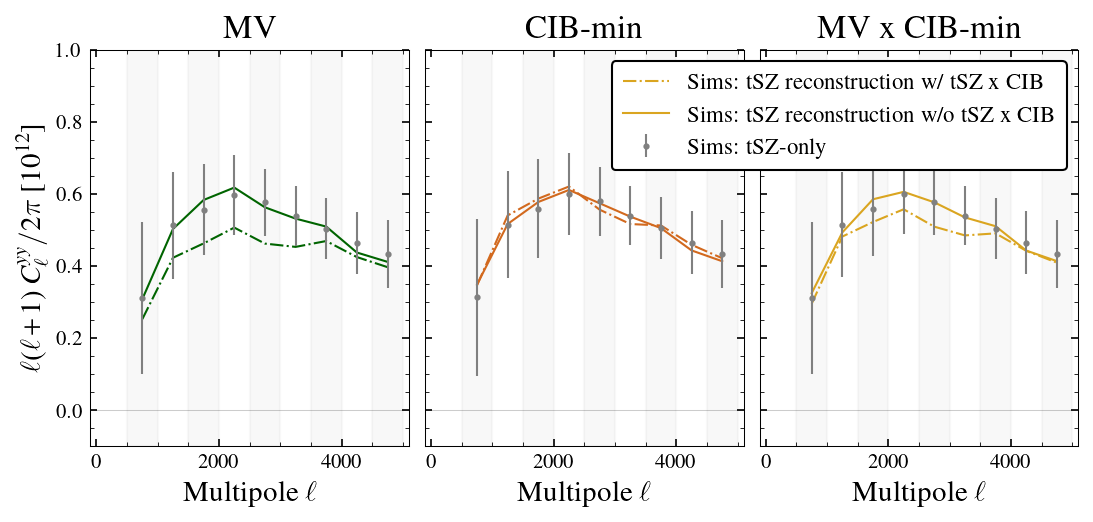

SystemExit: 

In [93]:
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()

op_ps_1d_dic = res_dic['op_ps_1d_dic']

m1_m2_ilc_comb_arr_to_plot = [('ymv', 'ymv'), ('ycibfree', 'ycibfree'), ('ycibfree', 'ymv'),]
show_error_decomposition = False #True ##False

clf()
fsval = 14
fig = figure(figsize = (8.5, 3.5))
subplots_adjust(wspace = 0.05)
tr, tc = 1, 1
ymin, ymax = -0.1, 1.
xmin, xmax = -100., 5100.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

#left panel - Final tSZ estimate for all ILC combinations with total error.
mkrval1, msval1 = 'o', 4.
mkrval2, msval2 = 'o', 4.
mkrval3, msval3 = 'o', 4.
xshiftval = -40 #-50 #-30.
xshiftdeltaval = abs(xshiftval)

pl_specs_dic = {('ymv', 'ymv'): ['darkgreen', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }


sim_comp_to_remove = 'cib_cmb_rad_ksz_noise'
sim_corr_comp = 'cib_cmb_rad_tsz_ksz_noise'
sim_uncorr_comp = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad'
#sim_comp = 'cmb_rad_tsz_ksz_noise_uncorrcib'
full_or_half1_half2_iter = 1
total_sims = 5
alphaval = 0.3
colorval = 'black'
def get_sims_and_mean(sim_comp, full_or_half1_half2_iter = 1, cl_to_remove = None):
    cl_sim_dic = op_ps_1d_dic[sim_comp]
    cl_arr = []
    for simno in range( total_sims ):
        el_, cl_ = cl_sim_dic[simno][full_or_half1_half2_iter][m1m2]
        if np.mean(cl_)<0.: continue #bad-sim
        if cl_to_remove is not None:
            cl_ = cl_ - cl_to_remove
        cl_arr.append( cl_ )
    cl_mean = np.mean(cl_arr, axis = 0)
    return el_, np.asarray( cl_arr ), cl_mean

for m1m2cntr, m1m2 in enumerate( m1_m2_ilc_comb_arr_to_plot ):
    cl_data_err = res_dic[m1m2]['data_error']
    ax = subplot(1, 3, m1m2cntr+1)
    colorval, labval, mkrval, msval = pl_specs_dic[m1m2]

    #sim comp to remove
    el_, cl_sim_to_remove_arr, cl_sim_to_remove_mean = get_sims_and_mean(sim_comp_to_remove, full_or_half1_half2_iter = 1)
    #sim tSZ only
    el_, cl_sim_tszonly_arr, cl_sim_tszonly_mean = get_sims_and_mean('tsz', full_or_half1_half2_iter = 0)
    #sims
    el_, cl_corr_sim_arr, cl_corr_sim_mean = get_sims_and_mean(sim_corr_comp, full_or_half1_half2_iter = 1, cl_to_remove = cl_sim_to_remove_mean)
    #sims
    el_, cl_uncorr_sim_arr, cl_uncorr_sim_mean = get_sims_and_mean(sim_uncorr_comp, full_or_half1_half2_iter = 1, cl_to_remove = cl_sim_to_remove_mean)
        
    #plot
    dl_fac = el_ * (el_+1)/2/np.pi * 1e12
    for cl_ in cl_corr_sim_arr:
        pass
        #plot( el_, dl_fac * cl_, alpha = alphaval, color = colorval, lw = 0.2)
    plot( el_, dl_fac * cl_corr_sim_mean, lw = 1., color = colorval, ls = '-.', label = r'Sims: tSZ reconstruction w/ tSZ x CIB')
    plot( el_, dl_fac * cl_uncorr_sim_mean, lw = 1., color = colorval, ls = '-', label = r'Sims: tSZ reconstruction w/o tSZ x CIB')
    errorbar( el_, dl_fac * cl_sim_tszonly_mean, yerr = dl_fac * cl_data_err, 
             lw = 1., 
             ls = 'None',
             marker = 'o', ms = 2., capsize = 0.,
             color = 'gray', label = r'Sims: tSZ-only')

    #shades
    ax = make_ver_shades(ax, el_)

    xlabel(r'Multipole $\ell$', fontsize = fsval)
    #setp(ax.get_xticklabels(), visible=False)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)
    if m1m2cntr == 2:
        legend(bbox_to_anchor = (1., 1.), loc = 1, ncol = 1, 
               fontsize = 11, framealpha = 1.)
    title(r'%s' %(labval), fontsize = fsval + 2)
    
    #legfsval = fsval - 4.    

show(); sys.exit()
        
        
    

legend(loc = 2, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)

show()



# Check the 2 ILC maps and the difference

In [ ]:
%matplotlib notebook
f1 = 'results/ymv_full_proj0.npy'
f2 = 'results/ycibfree_full_proj0.npy'

#masks
mask_fname = 'results/masks.npy'
mask_dic = np.load(mask_fname, allow_pickle=True).item()
print( mask_dic.keys() ); ##sys.exit()
apod_mask = mask_dic['apod_mask']
mask = mask_dic['mask']

fname_dic = {'ymv': f1, 'ycibfree': f2}
cmap = cm.RdBu_r
vmin, vmax = -10, 15. #SNR>=5
vmin, vmax = -5, 5. #None, None
yscalefac = 1e6

x1, x2, y1, y2 = 0, 1560, 0, 1560
x1, x2 = 250, 500
y1, y2 = 750, 1000

pl_arr = []
for to_plot_cntr, ilckey in enumerate( fname_dic ):
    fsval = 14
    curr_ymap = np.load(fname_dic[ilckey], allow_pickle=True)
    ny, nx = curr_ymap.shape

    mask_to_plot = mask #apod_mask * mask
    curr_ymap_to_plot = np.copy( curr_ymap ) * yscalefac# * mask_to_plot
    
    """
    imshow( curr_ymap_to_plot[y1:y2, x1:x2], vmin = vmin, vmax = vmax, cmap = cmap, 
                        #extent = [xmin, xmax, ymin, ymax],
            ); colorbar()
    show()
    """
    
    pl_arr.append( curr_ymap_to_plot )

diff_map_to_plot = pl_arr[0] - pl_arr[1]
"""
imshow( diff_map_to_plot[y1:y2, x1:x2], 
       vmin = vmin, vmax = vmax,
       cmap = cmap); colorbar()
show()
"""

clf()
imshow( diff_map_to_plot * mask, vmin = vmin, vmax = vmax,cmap = cmap); 
cbar = colorbar()
cbar.set_label(r'Copton $y$ [$10^{6}$]', fontsize = 14)
#xlim(x1, x2); ylim(y1, y2)
title(r'Diff (MV, CIB-min)', fontsize = 14)
show()



In [27]:
tmp = get_sim_tsz_cib(lmin_lmax_arr, key_for_sima, key_for_simb, undesired_comp_for_sima, undesired_comp_for_simb)
print(tmp)
    
    

[-1.34081437e-18 -4.68890689e-19 -2.62063485e-19 -1.37253534e-19
 -7.36678435e-20]


In [ ]:
final_full_sys_cov = full_sys_cov_dic['cib_tweaked_spt_only_max_tweak_0.2'] + \
                full_sys_cov_dic['rad_tweaked_max_tweak_0.2'] + \
                full_sys_cov_dic['cmb_withspiretcalerror'] + \
                full_sys_cov_dic['ksz']


In [214]:
curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m2, m3, op_ps_1d_dic, lmin_lmax_arr = [[500, 1500], [1500, 3000]])


[[5.62099670e-36 7.58433187e-37 5.39373430e-36 7.60260435e-37
  3.22939302e-37 1.38752060e-37 6.66292939e-38 3.12872394e-37
  1.36650200e-37 6.11971302e-38]
 [7.58433187e-37 3.02669104e-37 7.23076888e-37 2.97814704e-37
  9.88147698e-38 3.87703055e-38 2.07682902e-38 9.66147389e-38
  3.87925109e-38 2.02382105e-38]
 [5.39373430e-36 7.23076888e-37 5.32285226e-36 7.30878009e-37
  3.07955199e-37 1.30186299e-37 6.14631974e-38 2.99684026e-37
  1.29294185e-37 5.60088395e-38]
 [7.60260435e-37 2.97814704e-37 7.30878009e-37 2.99377833e-37
  9.80705716e-38 3.91264055e-38 2.08883871e-38 9.65239073e-38
  3.92848124e-38 2.03433172e-38]
 [3.22939302e-37 9.88147698e-38 3.07955199e-37 9.80705716e-38
  6.17301179e-38 2.04375609e-38 1.11956326e-38 5.89203824e-38
  2.02989627e-38 1.08867235e-38]
 [1.38752060e-37 3.87703055e-38 1.30186299e-37 3.91264055e-38
  2.04375609e-38 1.32643079e-38 4.92045914e-39 1.93764399e-38
  1.29921924e-38 4.86808268e-39]
 [6.66292939e-38 2.07682902e-38 6.14631974e-38 2.08883871e

SystemExit: 

In [213]:
m1, m2, m3 = m1m2_arr
curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m2, m3, op_ps_1d_dic, lmin_lmax_arr = [[500, 3000]])


[[5.62099670e-36 7.58433187e-37 3.22939302e-37 1.38752060e-37
  6.66292939e-38 5.39373430e-36 7.60260435e-37 3.12872394e-37
  1.36650200e-37 6.11971302e-38]
 [7.58433187e-37 3.02669104e-37 9.88147698e-38 3.87703055e-38
  2.07682902e-38 7.23076888e-37 2.97814704e-37 9.66147389e-38
  3.87925109e-38 2.02382105e-38]
 [3.22939302e-37 9.88147698e-38 6.17301179e-38 2.04375609e-38
  1.11956326e-38 3.07955199e-37 9.80705716e-38 5.89203824e-38
  2.02989627e-38 1.08867235e-38]
 [1.38752060e-37 3.87703055e-38 2.04375609e-38 1.32643079e-38
  4.92045914e-39 1.30186299e-37 3.91264055e-38 1.93764399e-38
  1.29921924e-38 4.86808268e-39]
 [6.66292939e-38 2.07682902e-38 1.11956326e-38 4.92045914e-39
  4.39608227e-39 6.14631974e-38 2.08883871e-38 1.05601323e-38
  5.07190645e-39 4.30666213e-39]
 [5.39373430e-36 7.23076888e-37 3.07955199e-37 1.30186299e-37
  6.14631974e-38 5.32285226e-36 7.30878009e-37 2.99684026e-37
  1.29294185e-37 5.60088395e-38]
 [7.60260435e-37 2.97814704e-37 9.80705716e-38 3.91264055e

SystemExit: 

In [219]:
m1, m2, m3 = m1m2_arr
#curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m1, m2, op_ps_1d_dic)#, lmin = 500, lmax = 5001)
curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m2, m3, op_ps_1d_dic, lmin_lmax_arr = [[500, 5001]])
#curr_diff_cov_v2 = tools.get_covs_for_difference_vectors(tmpels, m2, m3, op_ps_1d_dic, lmin_lmax_arr = [[500, 1500], [1500, 5001]])
tmpreclen = int( len(curr_diff_cov_v2)/2 )
curr_cov_11_v2 = curr_diff_cov_v2[:tmpreclen, :tmpreclen]
curr_cov_22_v2 = curr_diff_cov_v2[tmpreclen:, tmpreclen:]
curr_cov_12_v2 = curr_diff_cov_v2[tmpreclen:, :tmpreclen]
curr_cov_21_v2 = curr_diff_cov_v2[:tmpreclen, tmpreclen:].T
#imshow(curr_diff_cov_v2); colorbar(); show()

print( curr_cov_22/curr_cov_11_v2 )
print( curr_cov_33/curr_cov_22_v2 )
print( curr_cov_23/curr_cov_12_v2 )
#print( curr_cov_21_v2 )


[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [139]:
sim_tsz_cib_estimate_dic['cibmindata_tsz'][('ymv', 'ymv')][0.25].keys()

dict_keys([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41])

In [118]:
res_dic[m1].keys()

dict_keys(['els', 'data', 'sim', 'data_final', 'data_final_cluster_masked_dic', 'data_error', 'sims_dic', 'cl_for_sub_arr', 'cl_sim_all_signals', 'cl_arr_sim_tsz', 'sim_all_signals_keyname', 'sim_tsz_only', 'cl_sim_all_signals_full', 'sim_all_signals_full_keyname', 'noise', 'for_consistency_tests', 'cl_sys_dic', 'stat_cov', 'cl_arr_for_gau_cov', 'stat_cov_non_gau', 'cl_arr_for_non_gau_cov', 'total_cov', 'cov_sys_dic'])

In [70]:
res_dic[ilc_keyname1]['for_consistency_tests'].keys()

dict_keys(['cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_half_splits', 'data_full'])

In [ ]:
if (0):
    print('\n\nEfstathiou and McCarthy now')

    #SNR of Efstathiou and McCarthy
    tmpfname = 'data/Efstathiou_2025.txt'
    tmpels, tmpdlyy, tmpdlyy_err = np.loadtxt( tmpfname, unpack = True )

    linds = np.arange(len(tmpels))
    #linds = np.where(tmpels<2000)[0]
    #linds = np.where(tmpels>2000)[0]

    tmpels, tmpdlyy, tmpdlyy_err = tmpels[linds], tmpdlyy[linds], tmpdlyy_err[linds]

    tmpcov = np.eye( len(tmpdlyy) ) * tmpdlyy_err**2
    #print(tmpcov)

    tmpcov_inv = np.linalg.inv(tmpcov)
    tmpchi_sq_val = np.dot(tmpdlyy, np.dot(tmpdlyy, tmpcov_inv))
    tmpsnr = np.sqrt( tmpchi_sq_val )
    print( tmpsnr )


In [81]:
res_dic[ilc_keyname1]['sim_all_signals_keyname']

'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent'